In [2]:
# packages_to_have <- c('cowplot', 'reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'geomtextpath')

# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# packages = installed.packages()
# packages = packages[, "Package"]

# if (FALSE %in% (packages_to_have %in% packages)){
#     install.packages(packages_to_have)
# }

Sys.setenv(VROOM_TEMP_PATH = './vroom')
system("mkdir -p ./vroom")
system("rm ./vroom/*")

# To call python from R
library(IRdisplay)
library(car)

library(archive)
library(dplyr)
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(geomtextpath)
library(cowplot)
library(scales)
library(vroom)
library(zoo)
library(ggdist)
library(gghighlight)
library(ggrepel)
library(ggbreak)
library(grid)
library(lemon)
library(ggprism)
library(ggh4x)
library(ggExtra)
library(tibbletime)
library(snakecase)
library(foreach)
library(doParallel)
library(ggside)
library(ggbeeswarm)
library(multidplyr)
library(ggpubr)
library(Hmisc)
library(rstatix)
library(multcompView)
# library(gifski)
library(gganimate)

library(intergraph)
library(network)
library(ggnetwork)

library(purrr)
library(future.apply)
future::plan("multicore", workers = 20L)

theme_set(theme_prism())


Loading required package: carData


Attaching package: ‘dplyr’


The following object is masked from ‘package:car’:

    recode


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.2     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::recode() masks car::recode()
✖ purrr::some()   masks car::some()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘igraph’


The

In [1]:
fig <- function(width, heigth) {
  options(repr.plot.width = width, repr.plot.height = heigth)
}

center_reduction <- function(data, colvar) {
    colvar <- rlang::sym(colvar)
    data %>%
        inner_join(data %>% summarise(mean = mean(!!colvar), sd = sd(!!colvar))) %>%
        mutate(!!colvar := (!!colvar - mean)/sd) %>%
        select(-c("sd", "mean"))
}

In [4]:
# All this is implemented (plus bugfixes!) in the ggnewscale package:
# https://github.com/eliocamp/ggnewscale
# If you have any issues, I prefer it if you send them as issues here:
# https://github.com/eliocamp/ggnewscale/issues

#' Allows to add another scale
#'
#' @param new_aes character with the aesthetic for which new scales will be
#' created
#'
new_scale <- function(new_aes) {
  structure(ggplot2::standardise_aes_names(new_aes), class = "new_aes")
}

#' Convenient functions
new_scale_fill <- function() {
  new_scale("fill")
}

new_scale_color <- function() {
  new_scale("colour")
}

new_scale_colour <- function() {
  new_scale("colour")
}

new_scale_alpha <- function() {
  new_scale("alpha")
}

new_scale_y <- function() {
  new_scale("y")
}

#' Special behaviour of the "+" for adding a `new_aes` object
#' It changes the name of the aesthethic for the previous layers, appending
#' "_new" to them.
ggplot_add.new_aes <- function(object, plot, object_name) {
  plot$layers <- lapply(plot$layers, bump_aes, new_aes = object)
  plot$scales$scales <- lapply(plot$scales$scales, bump_aes, new_aes = object)
  plot$labels <- bump_aes(plot$labels, new_aes = object)
  plot
}


bump_aes <- function(layer, new_aes) {
  UseMethod("bump_aes")
}

bump_aes.Scale <- function(layer, new_aes) {
  old_aes <- layer$aesthetics[remove_new(layer$aesthetics) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  layer$aesthetics[layer$aesthetics %in% old_aes] <- new_aes

  if (is.character(layer$guide)) {
    layer$guide <- match.fun(paste("guide_", layer$guide, sep = ""))()
  }
  layer$guide$available_aes[layer$guide$available_aes %in% old_aes] <- new_aes
  layer
}

bump_aes.Layer <- function(layer, new_aes) {
  original_aes <- new_aes

  old_aes <- names(layer$mapping)[remove_new(names(layer$mapping)) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  old_geom <- layer$geom

  old_setup <- old_geom$handle_na
  new_setup <- function(self, data, params) {
    colnames(data)[colnames(data) %in% new_aes] <- original_aes
    old_setup(data, params)
  }

  new_geom <- ggplot2::ggproto(paste0("New", class(old_geom)[1]), old_geom,
    handle_na = new_setup
  )

  new_geom$default_aes <- change_name(new_geom$default_aes, old_aes, new_aes)
  new_geom$non_missing_aes <- change_name(new_geom$non_missing_aes, old_aes, new_aes)
  new_geom$required_aes <- change_name(new_geom$required_aes, old_aes, new_aes)
  new_geom$optional_aes <- change_name(new_geom$optional_aes, old_aes, new_aes)

  layer$geom <- new_geom

  old_stat <- layer$stat

  old_setup2 <- old_stat$handle_na
  new_setup <- function(self, data, params) {
    colnames(data)[colnames(data) %in% new_aes] <- original_aes
    old_setup2(data, params)
  }

  new_stat <- ggplot2::ggproto(paste0("New", class(old_stat)[1]), old_stat,
    handle_na = new_setup
  )

  new_stat$default_aes <- change_name(new_stat$default_aes, old_aes, new_aes)
  new_stat$non_missing_aes <- change_name(new_stat$non_missing_aes, old_aes, new_aes)
  new_stat$required_aes <- change_name(new_stat$required_aes, old_aes, new_aes)
  new_stat$optional_aes <- change_name(new_stat$optional_aes, old_aes, new_aes)

  layer$stat <- new_stat

  layer$mapping <- change_name(layer$mapping, old_aes, new_aes)
  layer
}

bump_aes.list <- function(layer, new_aes) {
  old_aes <- names(layer)[remove_new(names(layer)) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  names(layer)[names(layer) %in% old_aes] <- new_aes
  layer
}

change_name <- function(list, old, new) {
  UseMethod("change_name")
}

change_name.character <- function(list, old, new) {
  list[list %in% old] <- new
  list
}

change_name.default <- function(list, old, new) {
  nam <- names(list)
  nam[nam %in% old] <- new
  names(list) <- nam
  list
}

change_name.NULL <- function(list, old, new) {
  NULL
}

remove_new <- function(aes) {
  stringi::stri_replace_all(aes, "", regex = "(_new)*")
}


# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [3]:
generate_gif <- T
reload_big_data <- TRUE
parallel_loading_datasets <- 2
parallel_loading_datasets_small <- 22

GRAPH_ONE_COLUMN_HEIGHT <- 3
GRAPH_ONE_COLUMN_WIDTH <- 5
GRAPH_HALF_COLUMN_WIDTH <- 2.5
GRAPH_TWO_COLUMN_WIDTH <- 12

METRICS_PATH <- "metrics-arks"
METRICS_ARKS <- c(
    "metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45.tar.xz",
    "metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01.tar.xz",
#---
#---
#---
"last element that is here because last element should not have any comma in the end and that sucks hard time."
)
METRICS_ARKS <- METRICS_ARKS[-length(METRICS_ARKS)]

METRICS_GROUP <- str_match(METRICS_ARKS, "metrics_.*-(.*?)_valuation.*\\.tar\\.xz")
METRICS_GROUP <- METRICS_GROUP[, 2]
METRICS_GROUP_GROUP <- as.character(rep(list("toto"), length(METRICS_ARKS)))

length(METRICS_ARKS)
length(METRICS_GROUP)
length(METRICS_GROUP_GROUP)
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP))
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP_GROUP))

[1] 2

[1] 2

[1] 2

In [6]:
correct_names <- function(x) {
    return(
        x %>%
            mutate(metric_group_rich = case_when(
                metric_group == "auction" ~ "\\footnotesize{\\mbox{\\rmfamily\\bfseries GIRAFF}}",
                metric_group == "edge_ward" ~ "\\footnotesize{Edge\\dash{}ward}",
                metric_group == "edge_ward_furthest" ~ "\\footnotesize{Edge\\dash{}ward furthest}",
                metric_group == "edge_first" ~ "\\footnotesize{Edge\\dash{}first}",
                # metric_group == "edge_furthest" ~ "Edge furthest",
                metric_group == "edge_first_v2" ~ "\\footnotesize{Edge\\dash{}furthest}",
                TRUE ~ metric_group
            )) %>%
            mutate(metric_group = factor(metric_group, levels = c("edge_ward", "edge_ward_furthest", "edge_first", "edge_first_v2", "auction"), ordered = TRUE)) %>%
            # mutate(metric_group_rich = factor(metric_group_rich, levels = unique(metric_group), ordered = TRUE)) %>%
            rename(`Placement method` = metric_group_rich)
        # mutate(`Placement method` = factor(`Placement method`, levels = factor(unique(metric_group), ordered = TRUE), ordered = TRUE))
    )
}


Then, the dependencies

Load the the Python `integration.py` script to use its variable in R

In [5]:
fig(20, 20)

adjust_timestamps <- function(x) {
  # Careful where we put this, as the first measurement may not be the same accross all of the combined values for the same folder
  minvalue <- x %>%
      group_by(folder) %>%
      summarise(minvalue = min(timestamp)) %>%
      ungroup()

  return(
    x %>%
      inner_join(minvalue) %>%
      mutate(timestamp = timestamp - minvalue) %>%
      select(-minvalue)
  )
}

prepare <- function(x) {
  return(
    x %>%
      rename(timestamp = "_time") %>%
      rename(field = "_field") %>%
      rename(value = "_value") %>%
      mutate(value = as.numeric(value)) %>%
      # filter (timestamp != "_time") %>% # TODO remove this fix, it is here bnecause I forgot to remove the headers each time i concatenated the different influx outputs
      {
        .
      }
  )
}
prepare_convert <- function(x) {
  return(
    x %>%
      mutate(instance = to_snake_case(instance)) %>%
      {
        .
      }
  )
}

extract_function_name_info <- function(x) {
  # The first element is the input string
  info <- stringr::str_match(x$function_name, "(.+)-i([0-9]+)-c([0-9]+)-m([0-9]+)-l([0-9]+)-a([0-9]+)-r([0-9]+)-d([0-9]+)-n([0-9]+)-n([0-9]+)")
  return(
    x %>%
      ungroup() %>%
      mutate(docker_fn_name = info %>% .[, 2]) %>%
      mutate(function_index = info %>% .[, 3]) %>%
      mutate(cpu =  as.numeric(info %>% .[, 4])) %>%
      mutate(mem =  as.numeric(info %>% .[, 5])) %>%
      mutate(latency = as.numeric(info %>% .[, 6])/ 1000) %>%
      mutate(arrival = as.numeric(info %>% .[, 7])/ 1000) %>%
      mutate(request_interval = as.numeric(info %>% .[, 8])/ 1000) %>%
      mutate(duration = as.numeric(info %>% .[, 9])/ 1000) %>%
      mutate(nb_functions_requested_per_node = as.numeric(info %>% .[, 10])) %>%
      mutate(nb_functions_requested_total = as.numeric(info %>% .[, 11]))
  )
}


In [7]:
load_csv <- function(filename) {
    all_data <- purrr::map_df(METRICS_ARKS, ~ mutate(vroom(archive_read(paste(METRICS_PATH, .x, sep = "/"), file = filename), progress = FALSE, col_types = cols(), col_names = TRUE, delim = "\t", .name_repair = "unique") %>% distinct(),
        folder = tools::file_path_sans_ext(tools::file_path_sans_ext(.x)),
        metric_group = METRICS_GROUP[which(METRICS_ARKS == .x)],
        metric_group_group = METRICS_GROUP_GROUP[which(METRICS_ARKS == .x)]
    ))
    return(all_data)
}

load_single_csv <- function(arkfile, filename) {
    all_data <- vroom(archive_read(paste(METRICS_PATH, arkfile, sep = "/"), file = filename), progress = FALSE, col_types = cols(), col_names = TRUE, delim = "\t", .name_repair = "unique") %>%
        distinct() %>%
        mutate(
            folder = tools::file_path_sans_ext(tools::file_path_sans_ext(arkfile)),
            metric_group = METRICS_GROUP[which(METRICS_ARKS == arkfile)],
            metric_group_group = METRICS_GROUP_GROUP[which(METRICS_ARKS == arkfile)]
        )
    return(all_data)
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [8]:
names_raw <- load_csv("names.csv") %>%
  rename(instance_address = instance, instance = name) %>%
  select(instance, instance_address, folder) %>%
  distinct()

colnames(names_raw)

[1] "instance"         "instance_address" "folder"

In [9]:

registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
raw.latency <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
  load_single_csv(ark, "neighbor_latency.csv") %>%
    prepare() %>%
    prepare_convert() %>%
    inner_join(names_raw %>% rename(instance_to = instance_address, destination_name = instance), c("instance_to", "folder")) %>%
    mutate(destination_name = to_snake_case(destination_name))
})

gc()

colnames(raw.latency)
# latency %>% select(instance, destination_name) %>% distinct()


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2658037,142.0,4794982,256.1,4794982,256.1
Vcells,4560776,34.8,10146329,77.5,7717009,58.9


[1] "...1"               "result"             "table"             
 [4] "_start"             "_stop"              "timestamp"         
 [7] "value"              "field"              "_measurement"      
[10] "instance"           "instance_address"   "instance_to"       
[13] "folder"             "metric_group"       "metric_group_group"
[16] "destination_name"

In [10]:
node_connections <- load_csv("network_shape.csv") %>%
  mutate(latency = as.numeric(latency)) %>%
  mutate(source = to_snake_case(source), destination = to_snake_case(destination)) 

node_levels <- load_csv("node_levels.csv") %>% 
  rename(name = source, level_value = level) %>%
  mutate(
    name = to_snake_case(name),
    level = case_when(
      level_value == 0 ~ "Cloud",
      level_value == max(level_value) - 1 ~ "Edge+1",
      level_value == max(level_value) ~ "Edge",
      TRUE ~ paste("Cloud", as.character(level_value), sep = "+")
    )
  ) 
  # add_row(values = 0, name = "marketplace", level = "Cloud") %>%
  # mutate(level = factor(level, levels = unique(level_value), ordered = TRUE))
colnames(node_levels)

[1] "name"               "level_value"        "folder"            
[4] "metric_group"       "metric_group_group" "level"

In [14]:
node_connections_renamed <- node_connections %>% rename(instance = source, destination_name = destination, goal = latency)

latency <- raw.latency %>%
  select(destination_name, field, value, instance, timestamp, folder, metric_group, metric_group_group) %>%
  inner_join(node_connections_renamed %>% full_join(node_connections_renamed %>% mutate(toto=instance, instance = destination_name, destination_name = toto))) %>%
  mutate(diff = value - goal)

Joining with `by = join_by(instance, destination_name, goal, folder, metric_group, metric_group_group)`
Joining with `by = join_by(destination_name, instance, folder, metric_group, metric_group_group)`


## Distribution of the functions in the network

In [11]:
registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
functions.refused <- foreach (ark = METRICS_ARKS) %dopar% {
    tryCatch(
        {
            df <- load_single_csv(ark, "refused_function_gauge.csv")%>%
                prepare() %>%
                prepare_convert() %>%
                extract_function_name_info() %>%
                select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
                # distinct() %>%
                mutate(status = "refused") %>%
                group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
                summarise(n = n())
            return(df)
        },
        error = function(cond){
            df <- data.frame(instance = character(0), folder = character(0), metric_group = character(0), metric_group_group = character(0), load_type = character(0), latency_type = character(0), status = character(0), n = numeric(0))
            return(df)
        }
    )
}
functions.refused <- bind_rows(functions.refused)

registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
functions.failed <- foreach (ark = METRICS_ARKS) %dopar% {
    tryCatch(
        {
            df <- load_single_csv(ark, "send_fails.csv")%>%
                prepare() %>%
                prepare_convert() %>%
                rename(function_name = tag) %>%
                extract_function_name_info() %>%
                select(instance, folder, metric_group, metric_group_group) %>%
                # distinct() %>%
                mutate(status = "failed") %>%
                group_by(instance, folder, metric_group, metric_group_group, status) %>%
                summarise(n = n())
            return(df)
        },
        error = function(cond){
            df <- data.frame(instance = character(0), folder = character(0), metric_group = character(0), metric_group_group = character(0), status = character(0), n = numeric(0))
            return(df)
        }
    )
}

functions.failed <- bind_rows(functions.failed)

functions <- load_csv("provisioned_function_gauge.csv") %>%
    prepare() %>%
    prepare_convert() %>%
    extract_function_name_info() %>%
    select(instance, sla_id, folder, metric_group, metric_group_group) %>%
    # distinct() %>%
    mutate(status = "provisioned") %>%
    group_by(instance, folder, metric_group, metric_group_group, status) %>%
    summarise(n = n()) %>%
    full_join(functions.refused) %>%
    full_join(functions.failed) %>%
    {
        .
    }


colnames(functions)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
`summarise()` has grouped output by 'instance', 'folder', 'metric_group', 'metric_group_group'. You can override using the
`.groups` argument.
Joining with `by = join_by(instance, folder, metric_group, metric_group_group, status, n)`
Joining with `by = join_by(instance, folder, metric_group, metric_group_group, status, n)`


[1] "instance"           "folder"             "metric_group"      
[4] "metric_group_group" "status"             "n"                 
[7] "load_type"          "latency_type"

In [12]:
total <- functions %>%
    group_by(folder, instance, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(n))

functions_total <- functions %>%
    inner_join(total, by = c("instance", "folder", "metric_group", "metric_group_group", "load_type", "latency_type")) %>%
    # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
    group_by(folder, status, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(total), n = sum(n)) %>%
    mutate(ratio = n / total) %>%
    {
        .
    }

`summarise()` has grouped output by 'folder', 'instance', 'metric_group', 'metric_group_group', 'load_type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'status', 'metric_group', 'metric_group_group', 'load_type'. You can override
using the `.groups` argument.


In [13]:
bids_raw <- load_csv("bid_gauge.csv") %>% prepare() %>% prepare_convert()
# bids_raw %>% filter(value <= 0) %>% select(folder) %>% distinct()

bids_raw <- bids_raw %>% mutate(value = ifelse(value < 0 & value >= -0.001, 0, value))
bids_raw %>% filter(value < 0)
stopifnot(bids_raw %>% filter(value < 0) %>% summarise(n = n()) == 0)


New names:
• `` -> `...1`
New names:
• `` -> `...1`


...1,result,table,_start,_stop,timestamp,value,field,_measurement,bid_id,function_name,instance,sla_id,folder,metric_group,metric_group_group
<lgl>,<lgl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [15]:
provisioned_sla <- load_csv("function_deployment_duration.csv") %>%
  prepare() %>%
  prepare_convert() %>%
  select(bid_id, sla_id, folder, metric_group, metric_group_group) %>%
  distinct() %>%
  {
    .
  }
colnames(provisioned_sla)
# slice_sample(provisioned_sla, n=5)


New names:
• `` -> `...1`
New names:
• `` -> `...1`


[1] "bid_id"             "sla_id"             "folder"            
[4] "metric_group"       "metric_group_group"

In [16]:
bids_won_function <- bids_raw %>%
  select(sla_id, bid_id, instance, function_name, folder, metric_group, metric_group_group, value) %>%
  distinct() %>%
  inner_join(provisioned_sla, by = c("bid_id", "sla_id", "folder", "metric_group", "metric_group_group")) %>%
  mutate(winner = instance) %>%
  mutate(cost = value) %>%
  select(sla_id, function_name, folder, metric_group, metric_group_group, winner, cost) %>%
  {
    .
  }

In [17]:
registerDoParallel(parallel_loading_datasets_small)
raw.cpu.observed_from_fog_node <- foreach (ark = METRICS_ARKS) %dopar% {
        cpu <- load_single_csv(ark, "cpu_observed_from_fog_node.csv") %>%
                prepare() %>%
                prepare_convert()
        cpu %>%
                filter(field == "initial_allocatable") %>%
                rename(initial_allocatable = value) %>%
                inner_join(cpu %>% filter(field == "used") %>% rename(used = value), by = c("timestamp", "folder", "instance", "metric_group", "metric_group_group")) %>%
                mutate(usage = used / initial_allocatable) %>%
                select(instance, timestamp, usage, folder, metric_group, metric_group_group)
}
raw.cpu.observed_from_fog_node <- bind_rows(raw.cpu.observed_from_fog_node)


In [18]:
get_usage <- function(df_raw) {
    max_timestamp <- df_raw %>%
        select(timestamp, instance, folder) %>%
        group_by(instance, folder) %>%
        summarise(total_time = max(timestamp) - min(timestamp))

    df <- df_raw %>%
        filter(field == "initial_allocatable") %>%
        rename(initial_allocatable = value) %>%
        inner_join(df_raw %>% filter(field == "used") %>% rename(used = value), by = c("timestamp", "folder", "instance", "metric_group", "metric_group_group")) %>%
        mutate(usage = used / initial_allocatable) %>%
        select(instance, timestamp, usage, folder, metric_group, metric_group_group)
    stopifnot(nrow(df) * 2 == nrow(df_raw))

    df <- df %>%
        drop_na() %>%
        distinct() %>%
        group_by(instance, folder, metric_group, metric_group_group) %>%
        arrange(timestamp, .by_group = TRUE) %>%
        summarise(usage = sum(as.numeric(diff(timestamp), units = "secs") * rollmean(usage, 2))) %>%
        inner_join(max_timestamp, by = c("instance", "folder")) %>%
        mutate(usage_ratio = usage / as.numeric(total_time, units = "secs")) %>% # * 100%
        {
            .
        }

    folders <- df %>%
        ungroup() %>%
        select(folder, metric_group, metric_group_group) %>%
        distinct()

    missing_data <- expand.grid(
        instance = node_levels$name,
        folder = folders$folder
    ) %>%
        # inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
        inner_join(folders, by = c("folder"))

    df <- df %>%
        ungroup() %>%
        full_join(missing_data, by = c("instance", "folder", "metric_group", "metric_group_group")) %>%
        ungroup() %>%
        {
            .
        }

    df$usage_ratio[is.na(df$usage_ratio)] <- 0

    df
}

In [19]:

registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
raw.auc_usage.cpu <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
        load_single_csv(ark, "cpu_observed_from_fog_node.csv") %>%
                prepare() %>%
                prepare_convert() %>%
                get_usage()
})

gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2706609,144.6,4794982,256.1,4794982,256.1
Vcells,4742029,36.2,10146329,77.5,7717009,58.9


In [20]:
raw.auc_usage.mem <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
        load_single_csv(ark, "memory_observed_from_fog_node.csv") %>%
                prepare() %>%
                prepare_convert() %>%
                get_usage()
})

gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2706423,144.6,4794982,256.1,4794982,256.1
Vcells,4741718,36.2,10146329,77.5,7717009,58.9


In [21]:
total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group, winner) %>%
    summarise(earnings = sum(cost)) %>%
    {
        .
    }


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups`
argument.


In [22]:
grand_total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group) %>%
    summarise(grand_total = sum(cost))


`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


## Latencies and SLAs

In [23]:
errors <- tryCatch(
    {
        load_csv("iot_emulation_http_request_to_processing_echo_fails.csv") %>%
            prepare() %>%
            prepare_convert() %>%
            extract_function_name_info() %>%
            distinct()
    },
    error = function(cond) {
        columns <- c("instance", "job", "timestamp", "tag", "period", "folder", "metric_group", "latency", "value")
        df <- data.frame(instance = character(0), job = character(0), period = numeric(0), folder = character(0), metric_group = character(0), latency = character(0), value = numeric(0))
        return(df)
    }
)


In [24]:
colnames(latency)

[1] "destination_name"   "field"              "value"             
 [4] "instance"           "timestamp"          "folder"            
 [7] "metric_group"       "metric_group_group" "goal"              
[10] "toto"               "diff"

Joining with `by = join_by(folder)`
Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


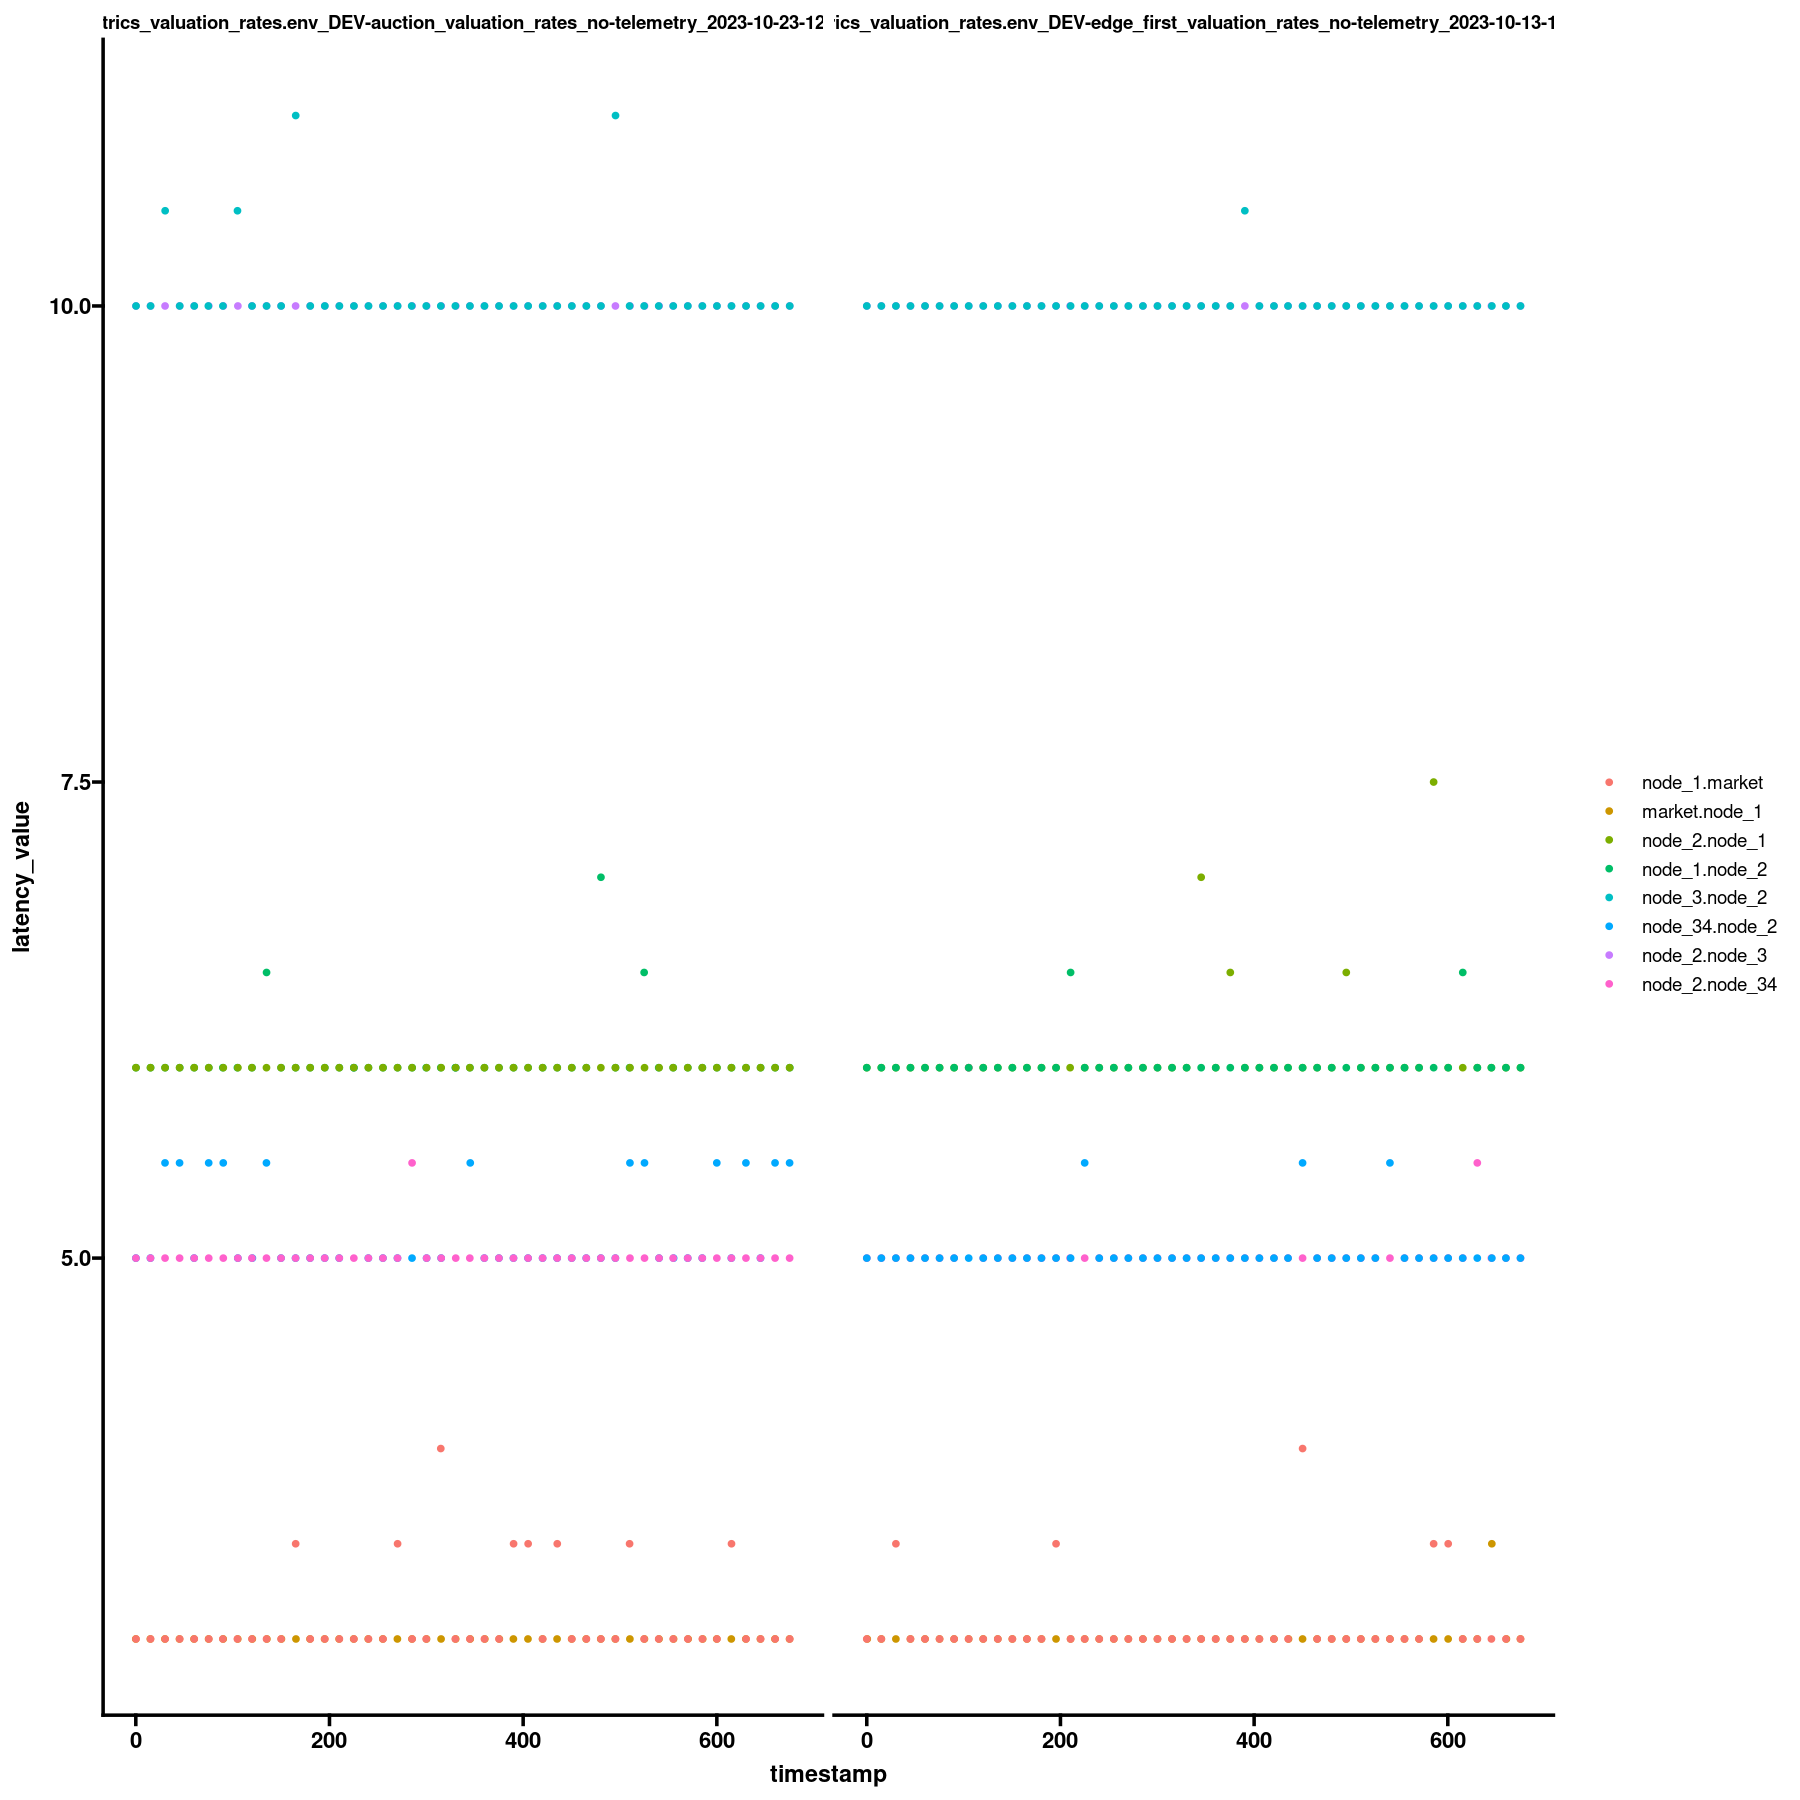

In [25]:
fig(15, 15)
latency %>%
  filter(field == "raw") %>%
  adjust_timestamps() %>%
  rename(source = instance, destination = destination_name, latency_value = value) %>%
  select(timestamp, source, destination, folder, latency_value, diff) %>%
  ggplot(aes(x= timestamp, y = latency_value, color = interaction(source, destination))) +
  facet_grid(cols = vars(folder)) +
  geom_point()
  # gghighlight(diff > 3)

In [26]:
time_interval <- 15 # secs

smooth_timestamps <- function(data) {
  return(
    data %>%
      group_by(folder) %>%
      mutate(timestamp_group = as.difftime((as.numeric(round(timestamp)) %/% time_interval + 1) * time_interval, units = "secs")) %>%
      ungroup()
  )
}
if (generate_gif) {


data <- latency %>%
  filter(field == "raw") %>%
  adjust_timestamps() %>%
  ungroup() %>%
  rename(source = instance, destination = destination_name, latency_value = value) %>%
  select(timestamp, source, destination, folder, latency_value, diff) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, source, destination, folder) %>%
  summarise(latency_value = mean(latency_value), diff = mean(diff)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup() %>%
  {
    .
  }


nodes <- load_csv("provisioned_functions.csv") %>%
  prepare() %>%
  adjust_timestamps() %>%
  group_by(timestamp, folder, instance) %>%
  mutate(provisioned = ifelse(value == 0, -1, value)) %>%
  summarise(provisioned = sum(provisioned), value = sum(value)) %>%
  group_by(folder, instance) %>%
  arrange(timestamp, .by_group = TRUE) %>%
  mutate(provisioned = lag(cumsum(provisioned), default = 0), total_provisioned = lag(cumsum(value), default = 0)) %>%
  rename(source = instance) %>%
  select(source, timestamp, folder, provisioned, total_provisioned) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, folder, source) %>%
  summarise(provisioned = last(provisioned), total_provisioned = last(total_provisioned)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup() %>%
  {
    .
  }
# nodes %>% filter(source == "rennes")
# nodes %>% filter(source == "st_greg_3_in")

cpu <- raw.cpu.observed_from_fog_node %>%
  adjust_timestamps() %>%
  rename(source = instance) %>%
  select(timestamp, source, folder, usage) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, folder, source) %>%
  summarise(usage = mean(usage)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup()

gif.apdex.raw <- load_csv("latency_header.csv") %>%
    prepare() %>%
    adjust_timestamps() %>%
    rename(function_name = tag) %>%
    extract_function_name_info() %>%
    smooth_timestamps() %>%
    inner_join(bids_won_function %>% select(sla_id, function_name, metric_group, metric_group_group, folder, winner), by = c("sla_id", "function_name", "folder", "metric_group_group", "metric_group")) %>%
    rename(measured_latency = value, source = winner) %>%
    group_by(timestamp_group, sla_id, folder, source) %>%
    summarise(satisfied_count = sum(measured_latency <= latency), total = n()) %>%
    mutate(apdex = satisfied_count / total)

gif.apdex.by_node <- gif.apdex.raw %>%
    group_by(timestamp_group, folder, source) %>%
    summarise(apdex = mean(apdex)) %>%
    rename(timestamp = timestamp_group) %>%
    ungroup()

# gif.apdex.by_function_and_node <- gif.apdex.raw %>%
#     group_by(timestamp_group, folder, source) %>%
#     summarise(apdex = mean(apdex)) %>%
#     rename(timestamp = timestamp_group) %>%
#     pivot_wider(names_from = apdex_category, values_from = apdex) %>%
#     fill(everything(), .direction = "downup") %>%
#     distinct() %>%
#     ungroup()

all_combinations <- data %>%
  select(folder, source, destination) %>%
  distinct() %>%
  full_join(
    data %>%
      select(timestamp) %>%
      distinct() %>%
      full_join(nodes %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(gif.apdex.by_node %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(cpu %>%
        select(timestamp) %>%
        distinct(), by = "timestamp"),
    by = character()
  )


data <- all_combinations %>%
  full_join(data, by = c("timestamp", "folder", "source", "destination")) %>%
  full_join(nodes, by = c("source", "timestamp", "folder")) %>%
  full_join(gif.apdex.by_node, by = c("source", "timestamp", "folder")) %>%
  full_join(cpu, by = c("source", "timestamp", "folder")) %>%
  group_by(folder, source, destination) %>%
  arrange(timestamp, .by_group = TRUE) %>%
  fill(diff, provisioned, total_provisioned) %>%
  # mutate(provisioned = ifelse(is.na(provisioned), 0, provisioned)) %>%
  # mutate(total_provisioned = ifelse(is.na(total_provisioned), 0, total_provisioned)) %>%
  # mutate(diff = ifelse(is.na(diff), 0, diff)) %>%
  # mutate(cpu_usage = ifelse(is.na(cpu_usage), 0, cpu_usage)) %>%
  ungroup() %>%
  {
    .
  }

globally_provisioned <- data %>%
  select(source, folder, timestamp, total_provisioned) %>%
  distinct() %>%
  group_by(folder, timestamp) %>%
  summarise(globally_provisioned = sum(total_provisioned)) %>%
  ungroup()

data <- data %>%
  # inner_join(globally_provisioned, by = c("folder", "timestamp")) %>%
  filter(source != destination) %>%
  select(source, destination, everything()) %>%
  rename(from = source, to = destination)
  # adjust_timestamps()

nrow(data)
}


Joining with `by = join_by(folder)`
`summarise()` has grouped output by 'timestamp_group', 'source', 'destination'. You can override using the `.groups`
argument.
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Joining with `by = join_by(folder)`
`summarise()` has grouped output by 'timestamp', 'folder'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'timestamp_group', 'folder'. You can override using the `.groups` argument.
Joining with `by = join_by(folder)`
`summarise()` has grouped output by 'timestamp_group', 'folder'. You can override using the `.groups` argument.
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Joining with `by = join_by(folder)`
`summarise()` has grouped output by 'timestamp_group', 'sla_id', 'folder'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'timestamp_group', 'folder'. You can override using the `.groups` argument.
Warning message:
“Using `by = character()` to perform a cross

[1] 736

In [27]:
fig(10, 10)

create_plot <- function(data) {
  net <- network(data, directed = TRUE, multiple = TRUE)
  net <- ggnetwork(net)
  name <- as.character(data$folder[1])
  duration <- max(data$timestamp) / time_interval
  print(duration)

  nudge_offset_x <- 0.05
  nudge_offset_y <- -0.3 / 2
  nudge_scale_y = 3

  pggnetwork <-
    ggplot(
      net,
      aes(x = x, y = y, xend = xend, yend = yend)
    ) + # mapping for edges
    geom_edges(
      arrow = arrow(length = unit(3, "pt"), type = "open"), # if directed
      curvature = 0.1,
      aes(size = diff, alpha = latency_value, color = diff)
    ) +
    scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
    scale_alpha_continuous() +
    new_scale_color() +
    geom_nodes(aes(size = provisioned, color = apdex),
      alpha = 0.5,
    ) +
    scale_colour_gradient(low = "white", high = "darkblue", na.value = "grey50") +
    new_scale_color() +
    geom_nodes(aes(size = provisioned / 16, color = usage),
      alpha = 1,
    ) +
    scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
    new_scale_color() +
    scale_color_manual(values = c("grey40", "grey80")) +
    geom_nodetext(aes(label = sprintf("sat: %1.2f", apdex)), color = "black", nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.3)/nudge_scale_y) +
    # geom_nodetext(aes(label = sprintf("ll: %1.2f", `Low-load.Low-latency`), colour = is.na(`Low-load.Low-latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.25) / nudge_scale_y) +
    # geom_nodetext(aes(label = sprintf("lh: %1.2f", `Low-load.High-latency`), colour = is.na(`Low-load.High-latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.2) / nudge_scale_y) +
    # geom_nodetext(aes(label = sprintf("hh: %1.2f", `High-load.High-latency`), colour = is.na(`High-load.High-latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.15) / nudge_scale_y) +
    # geom_nodetext(aes(label = sprintf("hl: %1.2f", `High-load.Low-latency`), colour = is.na(`High-load.Low-latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.1) / nudge_scale_y) +
    geom_nodetext(aes(label = sprintf("f: %02d/%02d", provisioned, total_provisioned)), color = "black", nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.05) / nudge_scale_y) +
    geom_nodetext(aes(label = sprintf("%s", vertex.names)), color = "grey80", nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0)/nudge_scale_y) +
    # geom_text(x = 0.05, y = 0.95, aes(label = paste0("Globally provisioned:", globally_provisioned)), color = "grey50", check_overlap = TRUE) +
    labs(title = "Time: {as.integer(frame_time)}",
    subtitle= sprintf("'%s'\n
    sat: satisfaction rate\n
    ll: low load low lat. ƒ satisfaction rate\n
    lh: low load high lat. ƒ satisfaction rate\n
    hh: high load high lat. ƒ satisfaction rate\n
    hl: high load low lat. ƒ satisfaction rate\n
    f: <current provisioned>/<total provisioned", name)) +
    transition_time(timestamp) +
    ease_aes("linear") +
    enter_fade() +
    exit_fade() +
    theme_blank() +
    theme(legend.position = "bottom")
  # +
  # facet_grid(cols = vars(folder))

  # out <- ggplot_build(pggnetwork)

  # rows <- max(out$layout$layout$ROW)
  # cols <- max(out$layout$layout$COL)
  print(duration)

  # print(pggnetwork[1])

  anim_save(filename = sprintf("%s.gif", name), animation = pggnetwork, renderer = magick_renderer(), nframes = duration, height = 1600, width = 2000)
}

if (generate_gif) {
  data_grouped <- data %>%
    # filter(timestamp < "15 secs") %>%w
    group_by(folder) %>%
    group_split()

  animations <- lapply(data_grouped, FUN = create_plot)
}
# create_plot(data_grouped[[1]])


Warning message in format_fortify(model = model, nodes = nodes, weights = weights, :
“duplicated edges detected”


Time difference of 46 secs


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


Time difference of 46 secs


Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”

Rendering [>-------------------------------------------] at 2.2 fps ~ eta: 21s
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”

Rendering [=>------------------------------------------] at 1.8 fps ~ eta: 24s
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”

Rendering [==>-----------------------------------------] at 1.8 fps ~ eta: 24s
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values

Time difference of 46 secs
Time difference of 46 secs


Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”

Rendering [>-------------------------------------------] at 2.9 fps ~ eta: 15s
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”

Rendering [=>------------------------------------------] at 2.4 fps ~ eta: 18s
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”

Rendering [==>-----------------------------------------] at 2.4 fps ~ eta: 18s
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values

In [28]:
# total_low_latency <- functions_total %>%
#   filter(status == "provisioned") %>%
#   filter(latency_type == "Low latency") %>%
#   group_by(folder, metric_group, metric_group_group, latency_type) %>%
#   summarise(total = sum(total))

# total <- functions_total %>%
#   filter(status == "provisioned") %>%
#   group_by(folder, metric_group, metric_group_group) %>%
#   summarise(total = sum(total))

# total_low_latency <- total_low_latency %>%
#   group_by(folder, metric_group, metric_group_group) %>%
#   inner_join(total, by = c("folder", "metric_group", "metric_group_group")) %>%
#   mutate(ratio_low_latency_functions = total.x / total.y) %>%
#   select(folder, metric_group, metric_group_group, ratio_low_latency_functions)


# ratio_low_latency <- functions_total %>%
#   filter(status == "provisioned") %>%
#   filter(latency_type == "Low latency") %>%
#   group_by(folder, metric_group, metric_group_group) %>%
#   summarise(n = sum(n)) %>%
#   inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
#   mutate(ratio_low_latency = n / total)

# ratio_total <- functions_total %>%
#   filter(status == "provisioned") %>%
#   group_by(folder, metric_group, metric_group_group) %>%
#   summarise(n = sum(n)) %>%
#   inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
#   mutate(ratio_total = n / total)


In [29]:
# colnames(total_low_latency)
# # colnames(apdex_data)


In [30]:
raw.deployment_times <-  load_csv("function_deployment_duration.csv") %>%
  prepare() %>%
  prepare_convert() %>%
  extract_function_name_info()
colnames(raw.deployment_times)
head(raw.deployment_times %>% select(function_name, everything()))


New names:
• `` -> `...1`
New names:
• `` -> `...1`


[1] "...1"                            "result"                         
 [3] "table"                           "_start"                         
 [5] "_stop"                           "timestamp"                      
 [7] "value"                           "field"                          
 [9] "_measurement"                    "bid_id"                         
[11] "function_name"                   "instance"                       
[13] "sla_id"                          "folder"                         
[15] "metric_group"                    "metric_group_group"             
[17] "docker_fn_name"                  "function_index"                 
[19] "cpu"                             "mem"                            
[21] "latency"                         "arrival"                        
[23] "request_interval"                "duration"                       
[25] "nb_functions_requested_per_node" "nb_functions_requested_total"

function_name,...1,result,table,_start,_stop,timestamp,value,field,_measurement,⋯,docker_fn_name,function_index,cpu,mem,latency,arrival,request_interval,duration,nb_functions_requested_per_node,nb_functions_requested_total
<chr>,<lgl>,<lgl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
echo-i33-c100-m256-l50-a129-r18-d451-n50-n100,NA,NA,0,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:37:10,236,value,function_deployment_duration,⋯,echo,33,100,256,0.050,0.129,0.018,0.451,50,100
echo-i40-c100-m256-l47-a479-r814-d263-n50-n100,NA,NA,1,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:43:00,185,value,function_deployment_duration,⋯,echo,40,100,256,0.047,0.479,0.814,0.263,50,100
echo-i29-c100-m256-l73-a552-r84837-d845-n50-n100,NA,NA,2,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:44:13,107,value,function_deployment_duration,⋯,echo,29,100,256,0.073,0.552,84.837,0.845,50,100
echo-i30-c100-m256-l63-a275-r122-d58-n50-n100,NA,NA,3,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:39:36,98,value,function_deployment_duration,⋯,echo,30,100,256,0.063,0.275,0.122,0.058,50,100
echo-i38-c100-m256-l108-a580-r90155-d7-n50-n100,NA,NA,4,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:44:41,165,value,function_deployment_duration,⋯,echo,38,100,256,0.108,0.580,90.155,0.007,50,100
echo-i5-c100-m256-l70-a53-r242-d565-n50-n100,NA,NA,5,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:35:54,123,value,function_deployment_duration,⋯,echo,5,100,256,0.070,0.053,0.242,0.565,50,100


In [31]:
# raw.nb_functions <- load_csv("nb_functions.csv") %>%
#     rename(load_type = load, latency_type = latency) %>%
#     mutate(
#     instance = to_snake_case(instance),
#     load_type = case_when(
#         load_type == "low" ~ "Low load",
#         load_type == "high" ~ "High load",
#         TRUE ~ "unimplemented",
#     ),
#     latency_type = case_when(
#         latency_type == "low" ~ "Low latency",
#         latency_type == "high" ~ "High latency",
#         TRUE ~ "unimplemented",
#     ))


# raw.nb_functions.total <- raw.nb_functions %>%
#     group_by(folder, metric_group_group, metric_group, load_type, latency_type) %>%
#     summarise(total = sum(value)) %>%
#     mutate(folder = gsub(".tar.xz","", folder))

# count.total <- raw.nb_functions.total %>% 
#     inner_join(raw.nb_functions.total %>% 
#         ungroup() %>%
#         select(folder, total, latency_type, load_type) %>%
#         distinct() %>%
#         group_by(folder) %>%
#         summarise(sum = sum(total))) %>%
#     select(folder, metric_group, sum, total, latency_type, load_type) %>%
#     mutate(ratio = total/sum)



# raw.function_low_latency_load_category <- count.total %>%
#     filter(latency_type == "Low latency" & load_type == "High load") %>%
#     select(-c(latency_type, load_type)) %>%
#     ungroup() %>%
#     select(folder, metric_group, ratio, sum) %>%
#     distinct() %>%
#     rename(category = ratio, requests = sum)

#     # raw.function_low_latency_load_category  %>% group_by(request, category, metric_group) %>% summarise(tot = n())
# # count.total
# fig(15,5)
# raw.function_low_latency_load_category %>%
#     ggplot(aes(x = as.factor(category), group = factor(requests), fill = factor(requests))) +
#     geom_bar(position = "dodge") +
#     facet_wrap(~metric_group)


In [32]:
jains_index <- function(allocations) {
  num_users <- length(allocations)
  sum_allocations <- sum(allocations)
  sum_square_allocations <- sum(allocations^2)
  index <- (sum_allocations^2) / (num_users * sum_square_allocations)
  return(index)
}

# earnings.total_per_instance <- bids_won_function %>%
#   group_by(folder, metric_group, metric_group_group, winner) %>%
#   summarise(earnings = sum(cost))

# folders <- earnings.total_per_instance %>%
#   ungroup() %>%
#   select(folder, metric_group, metric_group_group) %>%
#   distinct()

# missing_data <- expand.grid(
#   winner = node_levels$name,
#   folder = folders$folder
# ) %>%
#   inner_join(folders) %>%
#   anti_join(earnings.total_per_instance %>% ungroup() %>% select(folder, winner))

# earnings.total_per_instance <- earnings.total_per_instance %>%
#   full_join(missing_data, by = c("winner", "folder", "metric_group", "metric_group_group")) %>%
#   mutate(earnings = ifelse(is.na(earnings), 0, earnings)) %>%
#   ungroup() 

# earnings.total <- earnings.total_per_instance %>%
#   group_by(folder, metric_group, metric_group_group) %>%
#   summarise(earnings = sum(earnings))

# earnings.jain <- earnings.total_per_instance %>%
#   inner_join(earnings.total %>% rename(total = earnings), by = c("folder", "metric_group", "metric_group_group")) %>%
#   mutate(earnings_ratio = earnings / total)

# # Calculate Jain's Fairness Index for each group using dplyr
# spider_all.earnings.ratio <- earnings.jain %>%
#   group_by(metric_group, folder, winner, metric_group_group) %>%
#   rename (score = earnings_ratio) %>%
#   mutate(score_type_rich = "Earning shares") 
  
# spider_all.earnings.ratio.highest <- spider_all.earnings.ratio %>%
#   group_by(metric_group, folder, metric_group_group) %>%
#   mutate(score = 1/score) %>%
#   worst_5() %>%
#   mutate(score = 1/score) %>%
#   filter(data_focus == "Worst 5%") %>%
#   mutate(score_type_rich = "Earning shares\n(highest)") %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE)

#  spider_all.earnings.ratio <-  spider_all.earnings.ratio %>%
#   group_by(metric_group, folder, metric_group_group) %>%
#   worst_5() %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE)

# spider_all.earnings.jain <- earnings.jain %>%
#   group_by(metric_group, folder, metric_group_group) %>%
#   summarise(jains_index = jains_index(earnings_ratio), n = n()) %>%
#   rename(score = jains_index ) %>%
#   mutate(score_type_rich = "Jain's index") %>%
#   mutate(data_focus = "All") %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 

# spider_all.auc_usage.cpu <- raw.auc_usage.cpu %>%
#   select(metric_group, folder, instance, usage_ratio, metric_group_group) %>%
#   rename(source = instance, score = usage_ratio) %>%
#   mutate(score = as.numeric(score)) %>%
#   mutate(score_type_rich = "CPU Usage") %>%
#   group_by(score_type_rich, metric_group, folder, metric_group_group) %>%
#   worst_5() %>%
#   ungroup %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 



# spider_all.auc_usage.mem <- raw.auc_usage.mem %>%
#   select(metric_group, folder, instance, usage_ratio, metric_group_group) %>%
#   rename(source = instance, score = usage_ratio) %>%
#   mutate(score = as.numeric(score)) %>%
#   mutate(score_type_rich = "Mem Usage") %>%
#   group_by(score_type_rich, metric_group, folder, metric_group_group) %>%
#   worst_5() %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 

# spider_all.functions_total <- functions_total %>%
#     filter(status == "provisioned") %>%
#     inner_join(raw.nb_functions.total %>% rename(all = total)) %>%
#     mutate (score = n / all) %>%
#     mutate(score_type_rich = sprintf("Provisioned fns\n%s %s", load_type, latency_type)) %>%
#     ungroup() %>%
#     select(score, score_type_rich, folder, metric_group, metric_group_group)  %>%
#     mutate(data_focus = "All") 


# spider_all.deployment_times <- raw.deployment_times %>%
#   ungroup() %>%
#   select(load_type, sla_id, load_type, latency_type, function_name, folder,  metric_group, value, metric_group_group) %>%
#   mutate(score = 1000/value) %>%
#   mutate(score_type_rich = sprintf("Deployment time\n%s %s", load_type, latency_type)) %>%
#   select(score, score_type_rich, folder, metric_group, sla_id, metric_group_group) %>%
#   group_by(folder, metric_group, score_type_rich, metric_group_group) %>%
#   worst_5() %>%
#   mutate(score = 1/score) %>%
#   summarySE("score", c("folder", "score_type_rich", "metric_group", "data_focus", "metric_group_group"), na.rm = TRUE) 

# bounds <- function(df){
#   df %>% 
#     mutate(lower.ci.score = score - ci) %>%
#     mutate(upper.ci.score = score + ci) 
# }

In [33]:
# fig(15, 15)

# ecdf.earnings <- earnings.jain %>%
#     rename (score = earnings_ratio) %>%
#     inner_join(raw.function_low_latency_load_category) 

In [34]:
# colnames(functions)

# raw.nb_functions.total.full <- raw.nb_functions.total %>% 
#         ungroup() %>%
#         select(folder, total, latency_type, load_type) %>%
#         distinct() %>%
#         group_by(folder) %>%
#         summarise(total = sum(total))
# raw.nb_functions.total.ll <- raw.nb_functions.total %>% 
#         ungroup() %>%
#         filter(latency_type == "Low latency") %>%
#         select(folder, total, latency_type, load_type) %>%
#         distinct() %>%
#         group_by(folder) %>%
#         summarise(total = sum(total))



In [35]:
raw.nb_functions <- raw.deployment_times %>% 
    ungroup() %>%
    select(sla_id, folder, nb_functions_requested_total) %>%
    distinct() %>%
    group_by(folder, nb_functions_requested_total) %>%
    summarise(nb_actual_functions = n()) %>%
    mutate(nb_functions = nb_actual_functions / nb_functions_requested_total)

`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'folder', 'winner'. You can override using the `.groups` argument.
Joining with `by = join_by(winner, folder, metric_group)`
`summarise()` has grouped output by 'metric_group'. You can override using the `.groups` argument.
Joining with `by = join_by(folder)`
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


Warning message:
“Computation failed in `stat_compare_multiple_means()`
Caused by error in `mutate()`:
ℹ In argument: `data = map(.data$data, .f, ...)`.
Caused by error in `map()`:
ℹ In index: 1.
Caused by error in `assertthat_iv_has_enough_levels()`:
! Variable grouphas only one level. Remove it from the model.”


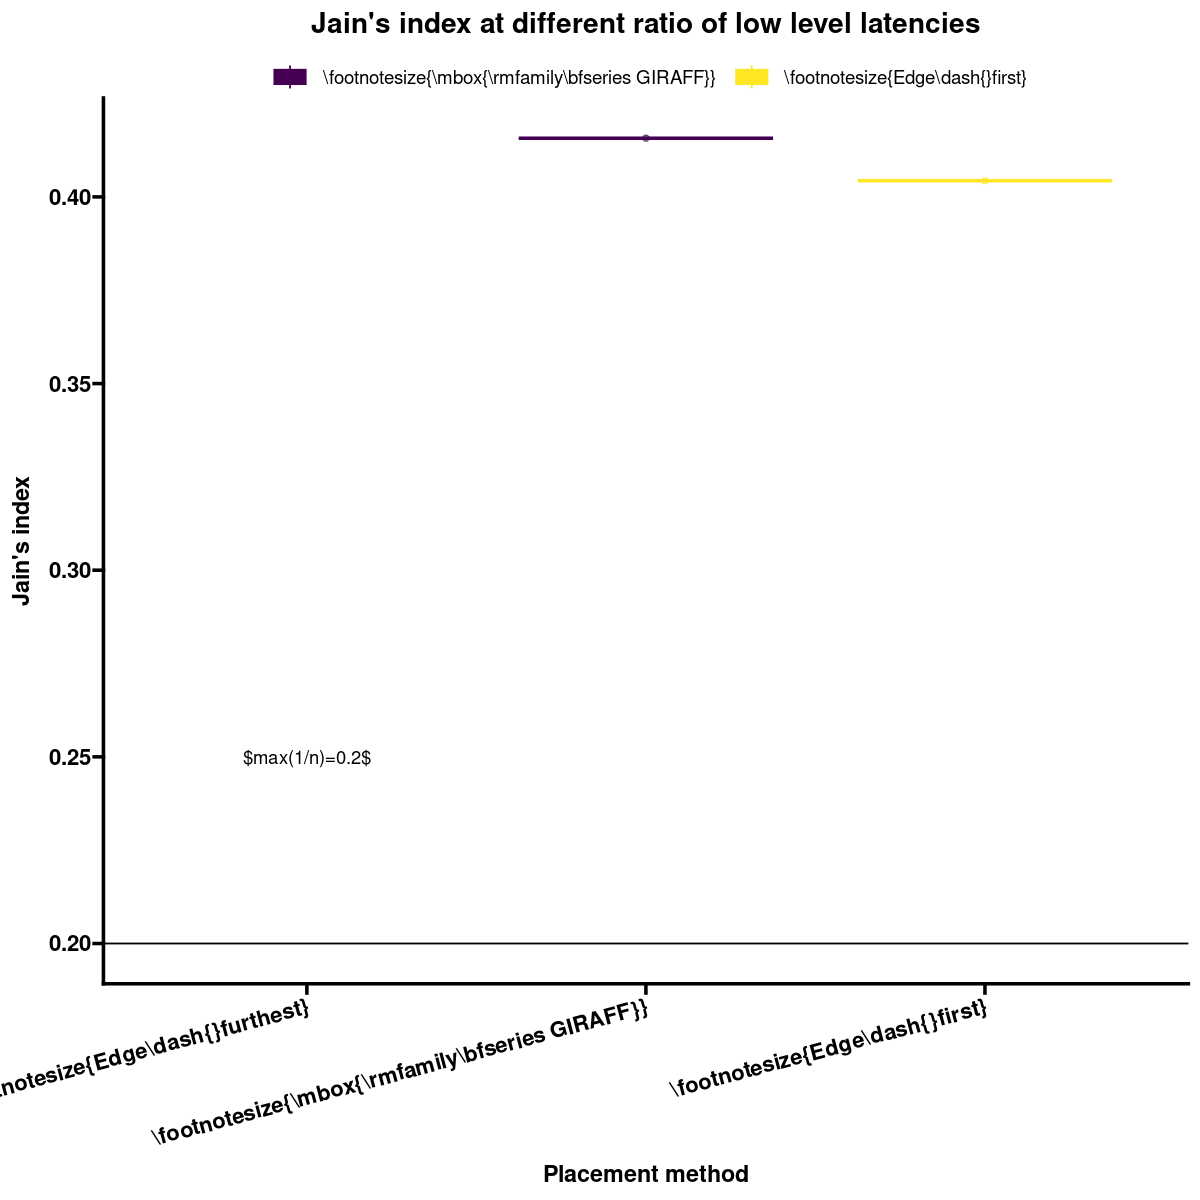

In [36]:
earnings.jains.plot.data.raw <- node_levels %>%
    rename(winner = name) %>%
    full_join(bids_won_function %>% group_by(folder, winner, metric_group) %>% summarise(earnings = sum(cost))) %>%
    mutate(earnings = ifelse(is.na(earnings), 0, earnings)) %>%
    group_by(metric_group, folder) %>%
    summarise(jains_index = jains_index(earnings), worst_case = round(1 / n(), 2), n = n()) %>%
    rename(score = jains_index ) %>%
    left_join(raw.nb_functions) %>%
    # left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
    # left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
    # rowwise() %>%
    # mutate(ratio_func_ll = total_func_ll / total_func) %>%
    correct_names()

plots.jains.w <- GRAPH_ONE_COLUMN_WIDTH
plots.jains.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.jains.caption <- "Jain's index at different ratio of low level latencies"
fig(plots.jains.w, plots.jains.h)

my_comparisons = combn(unique(earnings.jains.plot.data.raw$`Placement method`), 2)
my_comparisons = apply(my_comparisons, 2, list)
my_comparisons <- lapply(my_comparisons, unlist)
fig(10, 10)
plots.jains <- earnings.jains.plot.data.raw %>%
    ggplot(aes(alpha=1, x = `Placement method`, y = score, fill = `Placement method`, color = `Placement method`)) +
    # facet_grid(cols = vars(sprintf("%.1f%% low-latency ƒ", ratio_func_ll * 100))) +
    geom_hline(yintercept = max(earnings.jains.plot.data.raw$worst_case), color = "black") +
    annotate("text", x="\footnotesize{Edge\\dash{}furthest}", y=max(earnings.jains.plot.data.raw$worst_case)+.05, label=sprintf("$max(1/n)=%s$", max(earnings.jains.plot.data.raw$worst_case)), color="black") +
    geom_boxplot() +
    geom_beeswarm() +
    # stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
    stat_anova_test() +
    labs(
        x = "Placement method",
        y = "Jain's index"
    ) +
    scale_alpha_continuous(guide = "none") +
    guides(color = guide_legend(nrow = 1), shape = guide_legend(nrow = 1), size = guide_legend(nrow = 1)) +
    theme(legend.background = element_rect(
        fill = alpha("white", .7),
        size = 0.2, color = "white"),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
    ) +
    theme(legend.position = "top", legend.box = "vertical") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    theme(legend.spacing.y = unit(0, "cm"), legend.margin = margin(0, 0, 0, 0), legend.box.margin = margin(0, -10, -10, -10), )

plots.jains + labs(title = plots.jains.caption)


## Nb of respected SLAs

In [37]:
if (reload_big_data) {
    registerDoParallel(cl = parallel_loading_datasets, cores = parallel_loading_datasets)
    respected_sla.header.nb <- foreach (ark = METRICS_ARKS) %dopar% {

        # max_timestamp <- data %>%
        #     group_by(folder, metric_group, metric_group_group) %>%
        #     summarise(max_timestamp = max(timestamp))
        gc()

        load_single_csv(ark, "latency_header.csv") %>%
            prepare() %>%
            adjust_timestamps() %>%
            rename(function_name = tag) %>%
            extract_function_name_info() %>%
        # data %>%
            # left_join(max_timestamp) %>%
            group_by(sla_id, folder, metric_group, metric_group_group, function_name) %>%
            summarise(
                satisfied_count = sum(value <= latency),
                acceptable_count = sum(value <= latency + 0.001),
                alt_satisfied_count = sum(value / 2 <= latency), 
                alt_satisfied_count2 = sum(value / 4 <= latency), 
                alt_acceptable_count = sum(value / 2 <= latency + 0.01), 
                total = n(), 
                measured_latency = mean(value), 
                ran_for = max(timestamp) - min(timestamp), 
                # finished_before_end_expe = max(timestamp) < max_timestamp
                ) %>%
            mutate(count.satisfied = satisfied_count / total) %>%
            mutate(count.acceptable = acceptable_count / total) %>%
            mutate(count.alt2 = alt_satisfied_count2 / total) %>%
            mutate(count.alt = alt_satisfied_count / total)
    }

    respected_sla.header.nb <- bind_rows(respected_sla.header.nb)
    respected_sla.header.nb %>% write.csv(.,file = "./respected_sla.header.nb.csv")
}

gc()
respected_sla.header.nb <- read.csv("./respected_sla.header.nb.csv")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3057966,163.4,4794982,256.1,4794982,256.1
Vcells,5489165,41.9,12255594,93.6,7717009,58.9


In [38]:
# if (reload_big_data) {
#     registerDoParallel(cl = parallel_loading_datasets, cores = parallel_loading_datasets)
#     respected_sla.nb <- foreach (ark = METRICS_ARKS) %dopar% {

#         # max_timestamp <- data %>%
#         #     group_by(folder, metric_group, metric_group_group) %>%
#         #     summarise(max_timestamp = max(timestamp))
#         gc()


#         load_single_csv(ark, "latency.csv") %>%
#             prepare() %>%
#             adjust_timestamps() %>%
#             rename(function_name = tag) %>%
#             extract_function_name_info() %>%
#         # data %>%
#             # left_join(max_timestamp) %>%
#             group_by(sla_id, folder, metric_group, metric_group_group, function_name) %>%
#             summarise(
#                 satisfied_count = sum(value <= latency),
#                 acceptable_count = sum(value <= latency + 0.001),
#                 alt_satisfied_count = sum(value / 2 <= latency), 
#                 alt_satisfied_count2 = sum(value / 4 <= latency), 
#                 alt_acceptable_count = sum(value / 2 <= latency + 0.01), 
#                 total = n(), 
#                 measured_latency = mean(value), 
#                 ran_for = max(timestamp) - min(timestamp), 
#                 # finished_before_end_expe = max(timestamp) < max_timestamp
#                 ) %>%
#             mutate(count.satisfied = satisfied_count / total) %>%
#             mutate(count.acceptable = acceptable_count / total) %>%
#             mutate(count.alt2 = alt_satisfied_count2 / total) %>%
#             mutate(count.alt = alt_satisfied_count / total)
#     }

#     respected_sla.nb <- bind_rows(respected_sla.nb)
#     respected_sla.nb %>% write.csv(.,file = "./respected_sla.nb.csv")
# }

# gc()
# respected_sla.nb <- read.csv("./respected_sla.nb.csv")

In [39]:
respected_sla.header.nb %>% filter(measured_latency > 0) %>% group_by(folder) %>% count()

folder,n
<chr>,<int>
metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45,96
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,7


In [40]:
# respected_sla.header.nb %>%
#     left_join(respected_sla.nb %>%
#         select(sla_id, folder, measured_latency) %>%
#         rename(og_measured_latency = measured_latency)) %>%
#     extract_function_name_info() %>%
#     mutate(measured_latency = (og_measured_latency - abs(measured_latency)) * 1000) %>%
#     left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
#     left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
#     rowwise() %>%
#     mutate(ratio_func_ll = total_func_ll / total_func) %>%
#     group_by(folder, metric_group, latency_type, load_type) %>%
#     summarise(sd= sd(measured_latency), measured_latency = mean(measured_latency))

In [41]:
slice_sample(respected_sla.header.nb %>% filter(metric_group == "auction"), n = 2)

X,sla_id,folder,metric_group,metric_group_group,function_name,satisfied_count,acceptable_count,alt_satisfied_count,alt_satisfied_count2,alt_acceptable_count,total,measured_latency,ran_for,count.satisfied,count.acceptable,count.alt2,count.alt
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27,3def44a5-1740-44d7-838e-ac95da0dceda,metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45,auction,toto,echo-i25-c100-m256-l69-a553-r12481-d30-n50-n100,2,2,2,2,2,2,0.02250000,0.046,1,1,1,1
74,baa6e43c-af59-48ac-9a39-5610e867c82e,metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45,auction,toto,echo-i43-c100-m256-l79-a113-r321-d2553-n50-n100,9,9,9,9,9,9,0.01622222,2.475,1,1,1,1


In [44]:
colnames(respected_sla.header.nb)

[1] "X"                    "sla_id"               "folder"              
 [4] "metric_group"         "metric_group_group"   "function_name"       
 [7] "satisfied_count"      "acceptable_count"     "alt_satisfied_count" 
[10] "alt_satisfied_count2" "alt_acceptable_count" "total"               
[13] "measured_latency"     "ran_for"              "count.satisfied"     
[16] "count.acceptable"     "count.alt2"           "count.alt"

In [45]:
node_levels %>% group_by(folder) %>% summarise(nb_nodes = n())

folder,nb_nodes
<chr>,<int>
metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45,5
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,5


In [46]:
slice_sample(raw.nb_functions)

folder,nb_functions_requested_total,nb_actual_functions,nb_functions
<chr>,<dbl>,<int>,<dbl>
metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45,100,97,0.97
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,100,100,1.00


In [50]:
plots.nb_deployed.data <- respected_sla.header.nb %>%
    extract_function_name_info() %>%
    left_join(raw.nb_functions) %>%
    left_join(node_levels %>% group_by(folder) %>% summarise(nb_nodes = n())) %>%
    # mutate(nb_nodes_group = case_when(
    #     nb_nodes < 19 ~ "Danger zone 1",
    #     nb_nodes <= 34 ~ "$19 \\le n < 34$",
    #     nb_nodes < 112 ~ "Danger zone 2",
    #     nb_nodes <= 119 ~ "$112 \\le n \\le 119$",
    #     TRUE ~ "Danger zone 3",
    # )) %>%
    rename(nb_nodes_group = nb_nodes) %>%
    group_by(folder, metric_group, nb_nodes_group, nb_functions_requested_total) %>%
    summarise(funcs = n()) %>%
    mutate(nb_function = funcs / nb_functions_requested_total) %>%
    correct_names()

plots.nb_deployed.data

plots.nb_deployed.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.nb_deployed.w <- GRAPH_ONE_COLUMN_WIDTH

Joining with `by = join_by(folder, nb_functions_requested_total)`
Joining with `by = join_by(folder)`
`summarise()` has grouped output by 'folder', 'metric_group', 'nb_nodes_group'. You can override using the `.groups`
argument.


folder,metric_group,nb_nodes_group,nb_functions_requested_total,funcs,nb_function,Placement method
<chr>,<ord>,<int>,<dbl>,<int>,<dbl>,<chr>
metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45,auction,5,100,96,0.96,\footnotesize{\mbox{\rmfamily\bfseries GIRAFF}}
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,edge_first,5,100,7,0.07,\footnotesize{Edge\dash{}first}


In [47]:
raw.deployment_times %>% 
    select(folder, function_name) %>%
    distinct() %>%
    anti_join(respected_sla.header.nb %>% select(folder, function_name) %>% distinct())
    

Joining with `by = join_by(folder, function_name)`


folder,function_name
<chr>,<chr>
metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45,echo-i2-c100-m256-l49-a598-r1194-d329-n50-n100
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,echo-i13-c100-m256-l75-a224-r53-d971-n50-n100
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,echo-i10-c100-m256-l127-a463-r1421-d704-n50-n100
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,echo-i33-c100-m256-l14-a175-r6321-d189-n50-n100
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,echo-i12-c100-m256-l29-a308-r41837-d300-n50-n100
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,echo-i6-c100-m256-l78-a594-r4314-d290-n50-n100
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,echo-i35-c100-m256-l107-a304-r111-d6371-n50-n100
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,echo-i23-c100-m256-l129-a92-r8324-d1275-n50-n100
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,echo-i26-c100-m256-l23-a89-r3272-d214-n50-n100


In [48]:
plots.respected_sla.data <- respected_sla.header.nb %>%
    extract_function_name_info() %>%
    # left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
    # left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
    rowwise() %>%
    # mutate(ratio_func_ll = total_func_ll / total_func) %>%
    # mutate(satisfied_count = count.acceptable) %>%
    mutate(satisfied_count = abs(measured_latency - latency) / latency) %>%
    mutate(measured_latency = abs(measured_latency) / latency) %>%
    # mutate(ratio_func_ll = sprintf("%.1f%% low-latency ƒ", ratio_func_ll *100))  %>%
    correct_names() %>% 
    mutate(toto = "toto")
    # mutate(group = sprintf("%s\n%s\n%s", latency_type, load_type, ratio_func_ll))
    # mutate(group = latency_type)


In [49]:
generate_label_df <- function(TUKEY, variable){ 
     # Extract labels and factor levels from Tukey post-hoc 
     Tukey.levels <- TUKEY[[variable]][,4]
     Tukey.labels <- data.frame(multcompLetters(Tukey.levels)['Letters'])
     
     #I need to put the labels in the same order as in the boxplot :
     Tukey.labels$class_x=rownames(Tukey.labels)
     Tukey.labels=Tukey.labels[order(Tukey.labels$class_x) , ]
     return(Tukey.labels)
     }

anova_boxplot <- function(p, df, x, y, facet, mean_cb, outliers = c()){
     xvar <- rlang::sym(x)
     yvar <- rlang::sym(y)
     facetvar <- rlang::sym(facet)

     df <- df %>% 
          rename(value_y = !!y) %>%
          rename(class_x = !!x) %>%
          rename(var_facet = !!facetvar) %>%
          select(class_x, value_y, var_facet)

     max_yvalue <- max(df$value_y)
     min_yvalue <- min(df$value_y)

     min_mean <- df %>%
          group_by(var_facet, class_x) %>%
          summarise(mean = mean(value_y))
     min_mean <- min(min_mean$mean)/2
     max_pt <- max(df$value_y)

     for (facetk in as.character(unique(df$var_facet))) {   
          subdf.raw <- subset(df, var_facet==facetk)
          display(print(subdf.raw %>% filter(row_number() %in% outliers)))
          subdf <- subdf.raw %>% 
               select(-var_facet) %>%
               filter(!row_number() %in% outliers)

          ANOVA=aov(subdf$value_y ~ subdf$class_x)
          TUKEY <- TukeyHSD(x=ANOVA, 'subdf$class_x', conf.level=0.95)
          
          tryCatch(
               {
                    print("Shapiro (p should be ns)")
                    # Extract the residuals
                    aov_residuals <- residuals(object = ANOVA)
                    # Run Shapiro-Wilk test
                    print(shapiro.test(x = aov_residuals))
                    print("ANOVA")
                    display(summary(ANOVA))
                    print("TUKEY")
                    print(TUKEY)
                    display(plot(ANOVA, 1))
                    display(plot(ANOVA, 2))
               },
               error = function(e){
                    message("An error occured with the anova pre checks")
                    print(e)
               },
               warning = function(e){
                    message("A warning occured with the anova pre checks")
                    print(e)
                    return(NA)
               }
          )

          display_labels <- FALSE
          final.text <- NULL
          final.box <- tryCatch({
               labels <- generate_label_df(TUKEY , 'subdf$class_x')
               names(labels) <- c('Letters','class_x')
               yvalue <- aggregate(.~class_x, data=subdf, quantile, probs=.75)  
               display_labels <- summary(ANOVA)[[1]][["Pr(>F)"]][1] <= 0.05
               return(subdf.raw %>% inner_join(labels))
               },
               error = function(e){
                    return(subdf.raw)
               })

          print(final.box)
          
          if (display_labels){
               final.text <- merge(labels, yvalue)
               final.text$var_facet <- facetk
               final.text <- final.text %>% inner_join(subdf %>% group_by(class_x) %>% summarise(mean = mean(value_y)))
               p <- p + 
                    stat_summary(data = final.box, fun = mean, geom = "col", mapping = aes(x=class_x, y=value_y, fill = Letters)) +
                    geom_beeswarm(data = final.box, aes(x=class_x, y=value_y, fill=Letters, color = Letters)) +
                    geom_boxplot(data = final.box, aes(x=class_x, y=value_y, fill=Letters, color = Letters), outlier.shape = NA) +
                    geom_text(data = final.text,  alpha= 1, aes(x=class_x, y=min_mean, label=mean_cb(Letters, mean))) #vjust=-1.5, hjust=-.5

          }else{
               p <- p + 
                    stat_summary(data = final.box, fun = mean, geom = "col", mapping = aes(x=class_x, y=value_y)) +
                    geom_beeswarm(data = final.box, aes(x=class_x, y=value_y)) +
                    geom_boxplot(data = final.box, aes(x=class_x, y=value_y), outlier.shape = NA)
                    # geom_text(data = final.text,  alpha= 1, aes(x=class_x, y=min_mean, label=mean_cb("\\dash{}", mean) )) #vjust=-1.5, hjust=-.5
          }

          display(head(final.text))

          sumup.F <- summary(ANOVA)[[1]][["F value"]][1]
          sumup.p <- summary(ANOVA)[[1]][["Pr(>F)"]][1]
          sumup.p <- case_when(
               sumup.p < 0.001 ~ "$p<0.001$",
               sumup.p < 0.01 ~ "$p<0.01$",
               sumup.p < 0.05 ~ "$p<0.05$",
               # sumup.p < 0.1 ~ "$p<0.1$",
               TRUE ~ "$p$ is ns"
               )

          if (!is.null(final.text)){
               final.text <- final.text %>% filter(class_x == subdf$class_x[[1]]) %>% mutate(y = max_pt)

               p <- p + 
                    # geom_text(data = final.text,  alpha= 1, aes(x=class_x, y=min_yvalue, label=sprintf("\\footnotesize{$\\mu=%.1f%%$}",mean*100))) +
                    # geom_text(data = final.text,  alpha= 1, aes(x=class_x, y=min_yvalue, label=sprintf("%.1f%%",mean*100))) +
                    # stat_anova_test(data= final.box, mapping=aes(x=class_x, y=value_y))
                    # annotate(data=final.box, geom = "text", color="black", x= subdf$class_x[[1]], y = max_mean * 1.01, label=sprintf("\\footnotesize{Anova $F=%.1f$, %s}", sumup.F, sumup.p))
                    geom_text(data=final.text, aes(x= class_x, y = y * 1.01),hjust = 0, color = "black", label=sprintf("\\footnotesize{Anova $F=%.1f$, %s}", sumup.F, sumup.p))
          }

     }

     return(p)
}


`summarise()` has grouped output by 'folder', 'Placement method'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'var_facet'. You can override using the `.groups` argument.


class_x,value_y,var_facet
<chr>,<dbl>,<chr>


# A tibble: 0 × 3
# ℹ 3 variables: class_x <chr>, value_y <dbl>, var_facet <chr>


Warning message in qtukey(conf.level, length(means), x$df.residual):
“NaNs produced”


[1] "Shapiro (p should be ns)"


An error occured with the anova pre checks



NULL

<simpleError in shapiro.test(x = aov_residuals): sample size must be between 3 and 5000>
# A tibble: 2 × 3
  class_x                                               value_y var_facet
  <chr>                                                   <dbl> <chr>    
1 "\\footnotesize{\\mbox{\\rmfamily\\bfseries GIRAFF}}"   0.975 toto     
2 "\\footnotesize{Edge\\dash{}first}"                     0.998 toto     


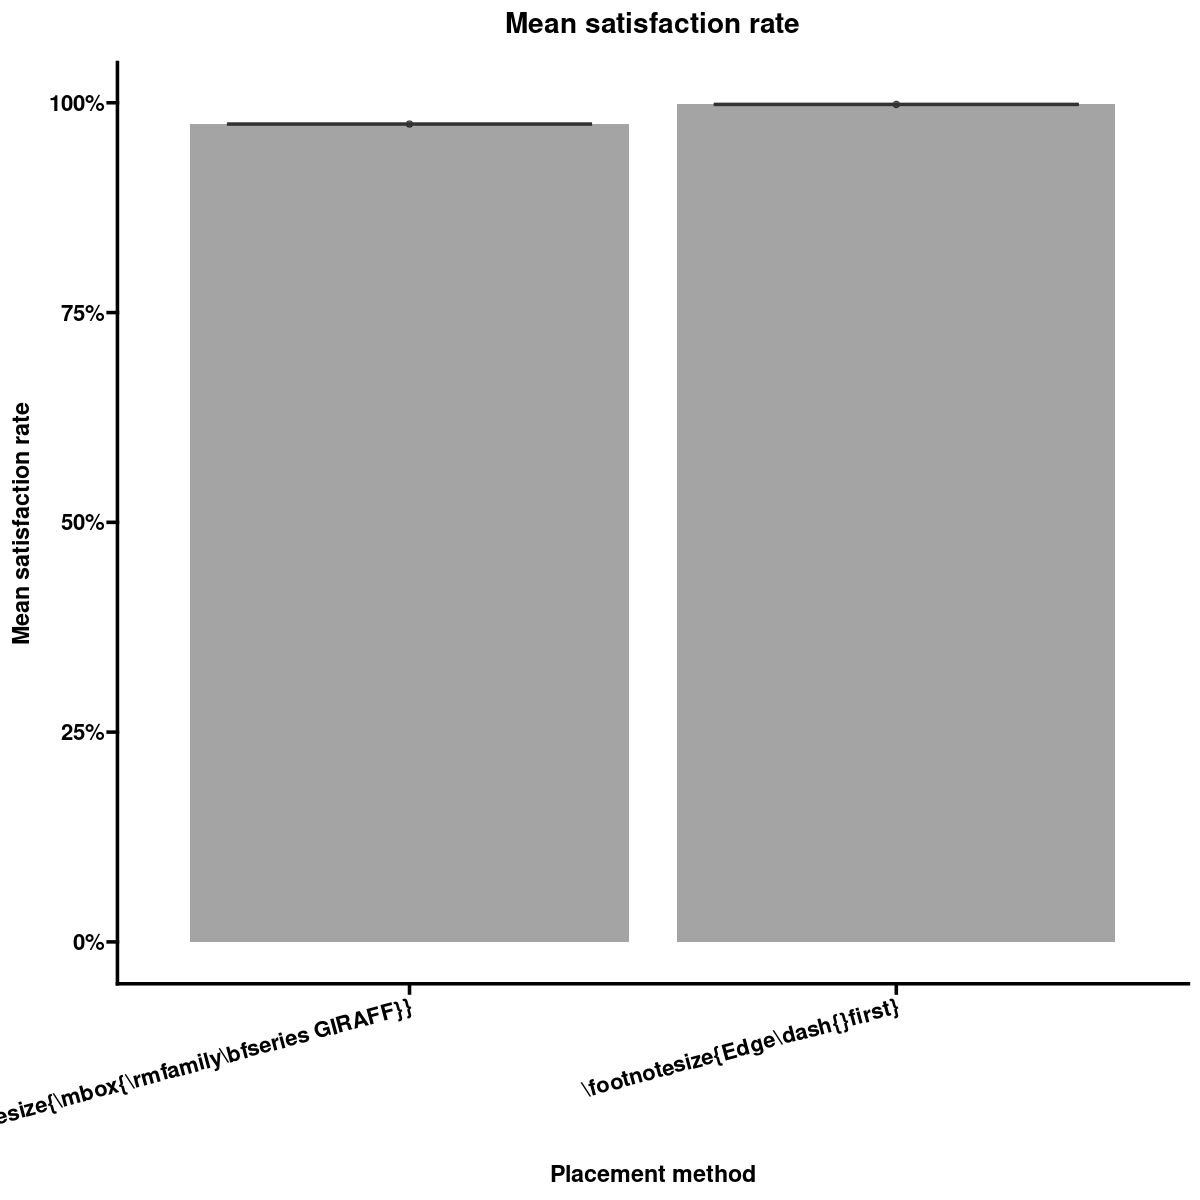

In [51]:
df <- plots.respected_sla.data %>%
    group_by(folder, `Placement method`, toto) %>%
    summarise(satisfied_count = mean(count.acceptable)) %>%
    ungroup()

p <- ggplot(data=df, aes(alpha=1)) +  
    #  facet_grid(~var_facet) +
     theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
        theme(axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
    theme(legend.position = "none") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T) +
    scale_y_continuous(labels = scales::percent) +
    labs(
        x = "Placement method",
        y = "Mean satisfaction rate")

fig(10, 10)
plots.respected_sla.w <- GRAPH_ONE_COLUMN_WIDTH
plots.respected_sla.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.respected_sla.caption <- "Mean satisfaction rate"
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1f%%$}",Letters, mean*100))
}
plots.respected_sla <- anova_boxplot(p, df, "Placement method", "satisfied_count", "toto", mean_cb, c(11))
plots.respected_sla + labs(title = plots.respected_sla.caption)

In [52]:
df <- plots.nb_deployed.data %>% ungroup()

fig(10, 10)

plots.nb_deployed.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.nb_deployed.w <- GRAPH_ONE_COLUMN_WIDTH
plots.nb_deployed.caption = "Ratio of deployed functions"
# mean_cb <- function(Letters, mean){
#     return(sprintf("%s\n\\footnotesize{$\\mu=%.1f%%$}",Letters, mean*100))
# }
# plots.nb_deployed <- anova_boxplot(p, df , "Placement method", "nb_functions", "nb_nodes_group", mean_cb, c(13))
# plots.nb_deployed + labs(title = plots.nb_deployed.caption)

# generate_label_df2 <- function(TUKEY, variable){
 
#      # Extract labels and factor levels from Tukey post-hoc 
#      Tukey.levels <- TUKEY[[variable]][,4]
#      Tukey.labels <- data.frame(multcompLetters(Tukey.levels)['Letters'])
     
#      #I need to put the labels in the same order as in the boxplot :
#      Tukey.labels$toto=rownames(Tukey.labels)
#      Tukey.labels=Tukey.labels[order(Tukey.labels$toto) , ]
#      return(Tukey.labels)
#      }

outliers = c(7,25,23)

df <- df %>% 
    rename(value_y = nb_functions) %>%
    rename(class_x = `Placement method`) %>%
    rename(var_facet = nb_nodes_group) %>%
    select(class_x, value_y, var_facet) %>%
    filter(!row_number() %in% outliers) %>%
    arrange(as.factor(var_facet))


max_yvalue <- max(df$value_y)
min_yvalue <- min(df$value_y)

min_mean <- df %>%
    group_by(var_facet, class_x) %>%
    summarise(mean = mean(value_y))
min_mean <- min(min_mean$mean)/2
max_pt <- max(df$value_y)

ANOVA=aov(value_y ~ class_x * var_facet, data = df)
TUKEY <- TukeyHSD(x=ANOVA, conf.level=0.95)

print("Shapiro (p should be ns)")
# Extract the residuals
aov_residuals <- residuals(object = ANOVA)
# Run Shapiro-Wilk test
print(shapiro.test(x = aov_residuals))
print("ANOVA")
display(summary(ANOVA))
print("TUKEY")
print(TUKEY)
display(plot(ANOVA, 1))
display(plot(ANOVA, 2))
        
labels <- generate_label_df(TUKEY , 'class_x:var_facet')
names(labels) <- c('Letters','cat')
labels <- labels %>% 
    rowwise() %>%
    mutate(cat = strsplit(cat, ":")) %>%
    mutate(class_x = cat[1]) %>%
    mutate(var_facet = cat[2])

df <- df %>%
    left_join(labels)

final.text <- df %>%
    group_by(var_facet, class_x, Letters) %>%
    summarise(mean = mean(value_y)) %>%
    mutate(value_y = min_mean) %>%
    arrange(class_x)

p <- df %>%
    ggplot(aes(x= class_x, y = value_y, alpha=1, fill = Letters)) +  
    facet_grid(cols = vars(factor(var_facet, levels = c("$19 \\le n < 34$", "$112 \\le n \\le 119$")))) +
    # facet_grid(cols = vars(var_facet)) +
     labs(
        x = "Placement method",
        y = "Jain's index"
    ) +
   scale_y_continuous(label = scales::percent) +
    scale_alpha_continuous(guide = "none") +
    labs(
        x = "Placement method",
        y = "% of functions placed",
    ) +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
    theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    theme(axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
    guides(colour = guide_legend(nrow = 1)) +
    theme(legend.position = "none") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T) +
    stat_summary(fun = mean, geom = "col", aes(color=Letters)) +
    geom_beeswarm(aes(color = Letters)) +
    geom_boxplot(aes(color = Letters), outlier.shape = NA) +
    geom_text(data = final.text, alpha= 1, aes(x=class_x, y=min_mean, label=sprintf("%s\n\\footnotesize{$\\mu=%.1f%%$}",Letters, mean*100)))


sumup.F <- summary(ANOVA)[[1]][["F value"]][1]
sumup.p <- summary(ANOVA)[[1]][["Pr(>F)"]][1]
sumup.p <- case_when(
    sumup.p < 0.001 ~ "$p<0.001$",
    sumup.p < 0.01 ~ "$p<0.01$",
    sumup.p < 0.05 ~ "$p<0.05$",
    TRUE ~ "$p$ is ns"
    )

p <- p +
    geom_text(data=final.text[2,] %>% mutate(value_y = max_yvalue), aes(x= class_x, y = value_y), color = "black", label=sprintf("\\footnotesize{Anova $F=%.1f$, %s}", sumup.F, sumup.p))

p

ERROR: [1m[33mError[39m in `rename()`:[22m
[33m![39m Can't rename columns that don't exist.
[31m✖[39m Column `nb_functions` doesn't exist.


`summarise()` has grouped output by 'var_facet'. You can override using the `.groups` argument.


class_x,value_y,var_facet
<chr>,<dbl>,<chr>


# A tibble: 0 × 3
# ℹ 3 variables: class_x <chr>, value_y <dbl>, var_facet <chr>


Warning message in qtukey(conf.level, length(means), x$df.residual):
“NaNs produced”


[1] "Shapiro (p should be ns)"


An error occured with the anova pre checks



NULL

<simpleError in shapiro.test(x = aov_residuals): sample size must be between 3 and 5000>
# A tibble: 2 × 3
  class_x                                               value_y var_facet
  <chr>                                                   <dbl> <chr>    
1 "\\footnotesize{\\mbox{\\rmfamily\\bfseries GIRAFF}}"   0.416 toto     
2 "\\footnotesize{Edge\\dash{}first}"                     0.404 toto     


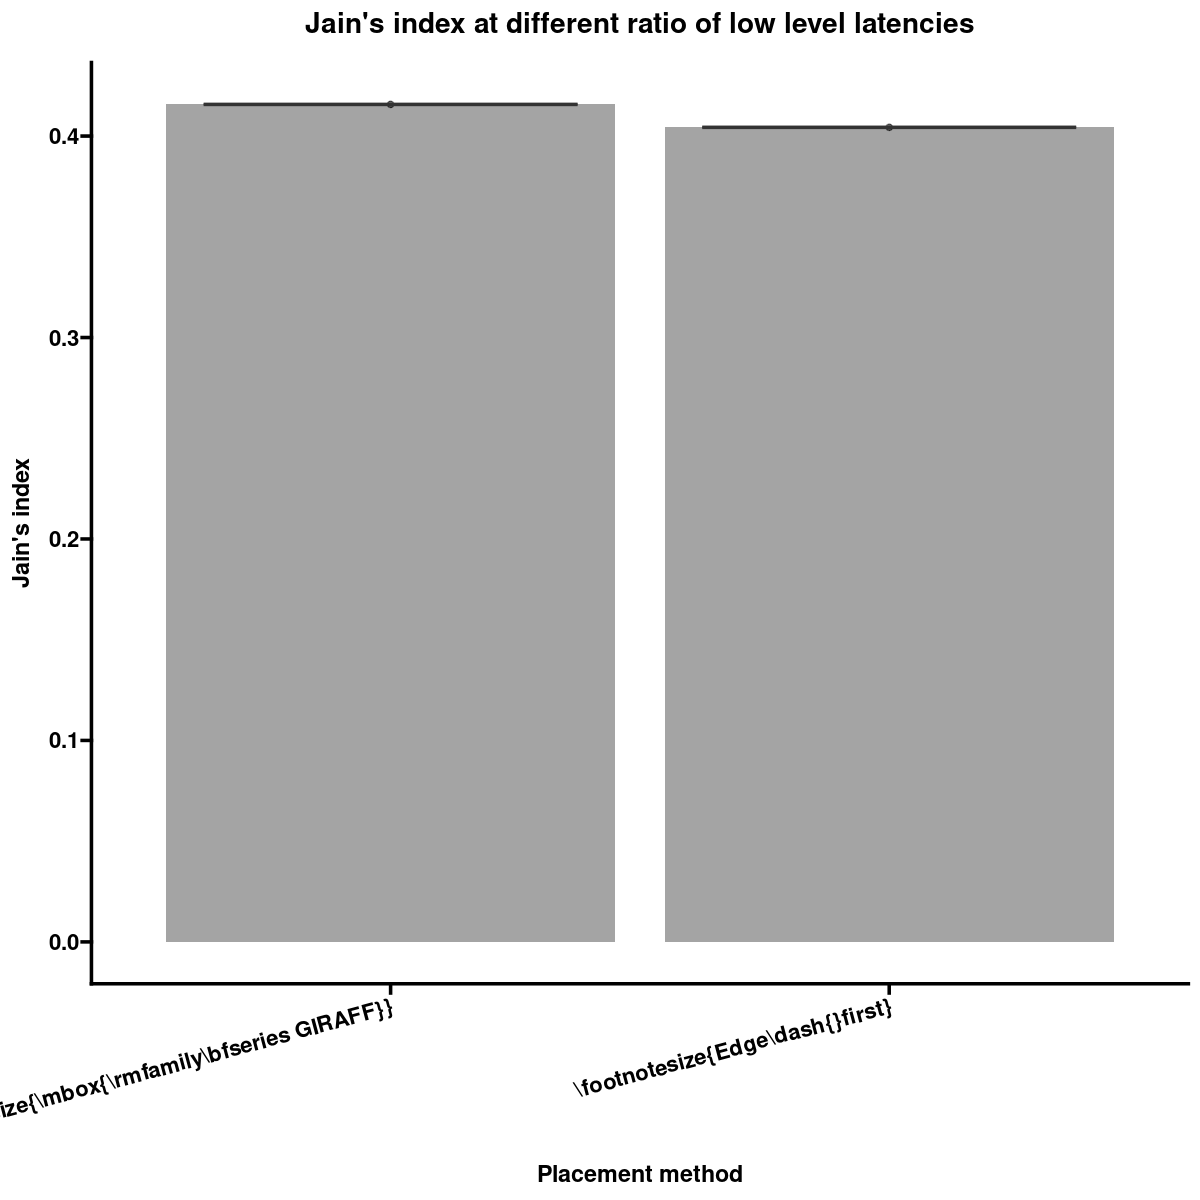

In [53]:
df <- earnings.jains.plot.data.raw %>% mutate(toto = "toto") %>% ungroup()
p <- ggplot(data= df, aes(alpha=1)) +
     labs(
        x = "Placement method",
        y = "Jain's index"
    ) +
    scale_alpha_continuous(guide = "none") +
    guides(color = guide_legend(nrow = 1), shape = guide_legend(nrow = 1), size = guide_legend(nrow = 1)) +
    theme(legend.background = element_rect(
        fill = alpha("white", .7),
        size = 0.2, color = "white"),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
    ) +
    theme(legend.position = "none") +
    # theme(legend.position = "top", legend.box = "vertical") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    theme(legend.spacing.y = unit(0, "cm"), legend.margin = margin(0, 0, 0, 0), legend.box.margin = margin(0, -10, -10, -10), )

fig(10, 10)
plots.jains.w <- GRAPH_ONE_COLUMN_WIDTH
plots.jains.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.jains.caption <- "Jain's index at different ratio of low level latencies"
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1f$}",Letters, mean))
}
plots.jains <- anova_boxplot(p, df , "Placement method", "score", "toto", mean_cb)
plots.jains + labs(title = plots.jains.caption)

In [54]:

# plots.respected_sla.w <- GRAPH_TWO_COLUMN_WIDTH
# plots.respected_sla.h <- GRAPH_ONE_COLUMN_HEIGHT
# plots.respected_sla.caption <- "Mean of ratio of satisfied responses from functions per ratio of deployed low latency functions"
# fig(plots.respected_sla.w, plots.respected_sla.h)

# fig (15, 15)
# plots.respected_sla.raw <- plots.respected_sla.data %>% 
#     # mutate(group = sprintf("%s\n%s\n%s", latency_type, load_type, ratio_func_ll)) %>%
#     group_by(folder, `Placement method`, group) %>%
#     # mutate(satisfied_count = satisfied_count / total) %>%
#     # summarise(satisfied_count = mean(satisfied_count / total)) %>%
#     summarise(satisfied_count = mean(count.satisfied)) %>%
#     # mutate(satisfied_count = alt_satisfied_count / total) %>%
#     # summarise(satisfied_count = mean(alt_satisfied_count / total), measured_latency = mean(measured_latency)) %>%
#     ggplot(aes(alpha=  1, x = `Placement method`, y = satisfied_count, color = `Placement method`)) +
#     facet_grid(cols = vars(group))+
#     stat_summary(fun = mean, geom = "col", mapping = aes(fill =`Placement method`)) +
#     geom_boxplot() +
#     geom_beeswarm() +
#     # stat_anova_test() +
#     # geom_text(data = generate_label_df(tHSD, 'lev'), aes(x = plot.labels, y = V1, label = labels)) +
#     # stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
#     stat_summary(fun = mean, geom = "text", mapping = aes(label=sprintf("\\footnotesize{$\\mu=%.1f%%$}",..y..*100)), position = position_stack(vjust = .5, reverse = T), color = "black") +
#     scale_alpha_continuous(guide = "none") +
#     theme(
#         axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)
#     ) +
#      theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7))) +
#         theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
#         theme(axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
#     theme(legend.position = "top") +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)+
#     scale_y_continuous(labels = scales::percent) +
#     labs(
#         x = "Placement method",
#         y = "Mean of mean of responses under $SLA_{max\\_latency}$")

# plots.respected_sla.raw + labs(title = plots.respected_sla.caption)

In [55]:

# my_comparisons = combn(unique(plots.respected_sla.data$`Placement method`), 2)
# my_comparisons = apply(my_comparisons, 2, list)
# my_comparisons <- lapply(my_comparisons, unlist)

# fig(15, 15)
# plots.respected_sla.data %>% 
#     group_by(folder, `Placement method`, latency_type, load_type, ratio_func_ll) %>%
#     summarise(measured_latency = mean(measured_latency)) %>%
#     ggplot(aes(x = `Placement method`, y = measured_latency, color = `Placement method`)) +
#     facet_grid(cols = vars(factor(ratio_func_ll)), rows = vars(sprintf("%s\n%s", latency_type, load_type))) +
#     geom_boxplot() +
#     # geom_beeswarm() +
#     scale_alpha_continuous(guide = "none") +
#     stat_compare_means(method = "t.test",  comparisons = my_comparisons, label = "p.signif") +
#      theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7))) +
#         theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
#         theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
#     theme(legend.position = "top") +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)+
#     labs(title = "mean of mean of latencies")


In [56]:
# # colnames(earnings.jain)

# center_reduction <- function(data, colvar) {
#     colvar <- rlang::sym(colvar)
#     data %>%
#         inner_join(data %>% summarise(mean = mean(!!colvar), sd = sd(!!colvar))) %>%
#         mutate(!!colvar := (!!colvar - mean)/sd) %>%
#         select(-c("sd", "mean"))
# }

# colnames(raw.deployment_times)

# raw.deployment_times.plot.data <- raw.deployment_times %>%
#     inner_join(raw.function_low_latency_load_category) %>%
#     mutate(fn_category = sprintf("%s %s", latency_type, load_type)) %>%
#     mutate(value = value / 1000)

# plots.deployment_times.w = 15
# plots.deployment_times.h = 4
plots.deployment_times.caption = "Deployment times per function category"
# fig(plots.deployment_times.w, plots.deployment_times.h)

# plots.deployment_times <- raw.deployment_times.plot.data %>% 
#     correct_names() %>%
#     ggplot(aes(alpha=0, x = factor(fn_category), y = value, group = `Placement method`, color = `Placement method`, fill = `Placement method`)) +
#     stat_cdfinterval(position = "dodge") +
#     scale_y_continuous(trans = "log10") +
#     scale_alpha_continuous(guide = "none") +
#     labs(subtitle = "Secondary graph is the CDF",
#     x = "Function category",
#     y = "Deployment time (s)"
#     ) +
#     theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7))) +
#         theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
#     theme(legend.position = c(.5, .90)) +
#     guides(colour = guide_legend(nrow = 1))

# plots.deployment_times    

In [57]:
colnames(raw.deployment_times)

slice_sample(raw.deployment_times %>% select(instance, everything()), n = 5)

[1] "...1"                            "result"                         
 [3] "table"                           "_start"                         
 [5] "_stop"                           "timestamp"                      
 [7] "value"                           "field"                          
 [9] "_measurement"                    "bid_id"                         
[11] "function_name"                   "instance"                       
[13] "sla_id"                          "folder"                         
[15] "metric_group"                    "metric_group_group"             
[17] "docker_fn_name"                  "function_index"                 
[19] "cpu"                             "mem"                            
[21] "latency"                         "arrival"                        
[23] "request_interval"                "duration"                       
[25] "nb_functions_requested_per_node" "nb_functions_requested_total"

instance,...1,result,table,_start,_stop,timestamp,value,field,_measurement,⋯,docker_fn_name,function_index,cpu,mem,latency,arrival,request_interval,duration,nb_functions_requested_per_node,nb_functions_requested_total
<chr>,<lgl>,<lgl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
marketplace,NA,NA,24,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:38:31,114,value,function_deployment_duration,⋯,echo,15,100,256,0.067,0.210,0.103,2.052,50,100
marketplace,NA,NA,75,1970-01-01,2023-10-13 10:01:39,2023-10-13 09:54:05,153,value,function_deployment_duration,⋯,echo,25,100,256,0.034,0.149,0.136,1.705,50,100
marketplace,NA,NA,29,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:37:15,115,value,function_deployment_duration,⋯,echo,27,100,256,0.076,0.134,0.129,3.333,50,100
marketplace,NA,NA,47,1970-01-01,2023-10-13 10:01:39,2023-10-13 10:00:44,169,value,function_deployment_duration,⋯,echo,3,100,256,0.112,0.548,1.563,0.855,50,100
marketplace,NA,NA,84,1970-01-01,2023-10-23 12:45:01,2023-10-23 12:39:35,166,value,function_deployment_duration,⋯,echo,10,100,256,0.064,0.274,0.493,0.189,50,100


In [58]:
plots.deploymenttimes.w <- GRAPH_ONE_COLUMN_WIDTH
plots.deploymenttimes.h <- 5
plots.deploymenttimes.caption = "Time to find a fog node for a function"
fig(plots.deploymenttimes.w, plots.deploymenttimes.h)
fig(15, 15)
# my_comparisons = combn(unique(plots.respected_sla.data$`Placement method`), 2)
# my_comparisons = apply(my_comparisons, 2, list)
# my_comparisons <- lapply(my_comparisons, unlist)

# plots.deploymenttimes.raw <- raw.deployment_times %>% 
#     group_by(folder, metric_group, latency_type) %>%
#     summarise(value = mean(value)) %>%
#     correct_names() %>%
#     ggplot(aes(alpha=0, y = value, x = `Placement method`, color = `Placement method`, shape = `Placement method`)) +
#     stat_summary(fun = mean, geom = "col", mapping = aes(fill =`Placement method`)) +
#     geom_boxplot() +
#     geom_beeswarm() +
#     stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
#     stat_summary(fun = mean, geom = "text", mapping = aes(label=sprintf("\\footnotesize{$\\mu=%.1fs$}",..y..)), position = position_stack(vjust = .5, reverse = T), color = "black") +
#     scale_alpha_continuous(guide = "none") +
#     labs(
#     y = "Mean time to deploy (s)",
#     x = "Placement method",
#     ) +
#        theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7)),
#         axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)

#                                   ) +
#         theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
#     theme(legend.position = c(.8, .5)) +
#     guides(colour = guide_legend(ncol = 1)) +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)+
#     facet_wrap(vars(latency_type))

# plots.deploymenttimes.raw + labs(title = plots.deployment_times.caption)

`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'var_facet'. You can override using the `.groups` argument.


class_x,value_y,var_facet
<chr>,<dbl>,<chr>


# A tibble: 0 × 3
# ℹ 3 variables: class_x <chr>, value_y <dbl>, var_facet <chr>


Warning message in qtukey(conf.level, length(means), x$df.residual):
“NaNs produced”


[1] "Shapiro (p should be ns)"


An error occured with the anova pre checks



NULL

<simpleError in shapiro.test(x = aov_residuals): sample size must be between 3 and 5000>
# A tibble: 2 × 3
  class_x                                               value_y var_facet
  <chr>                                                   <dbl> <chr>    
1 "\\footnotesize{\\mbox{\\rmfamily\\bfseries GIRAFF}}"    159. sdlkfjh  
2 "\\footnotesize{Edge\\dash{}first}"                      168. sdlkfjh  


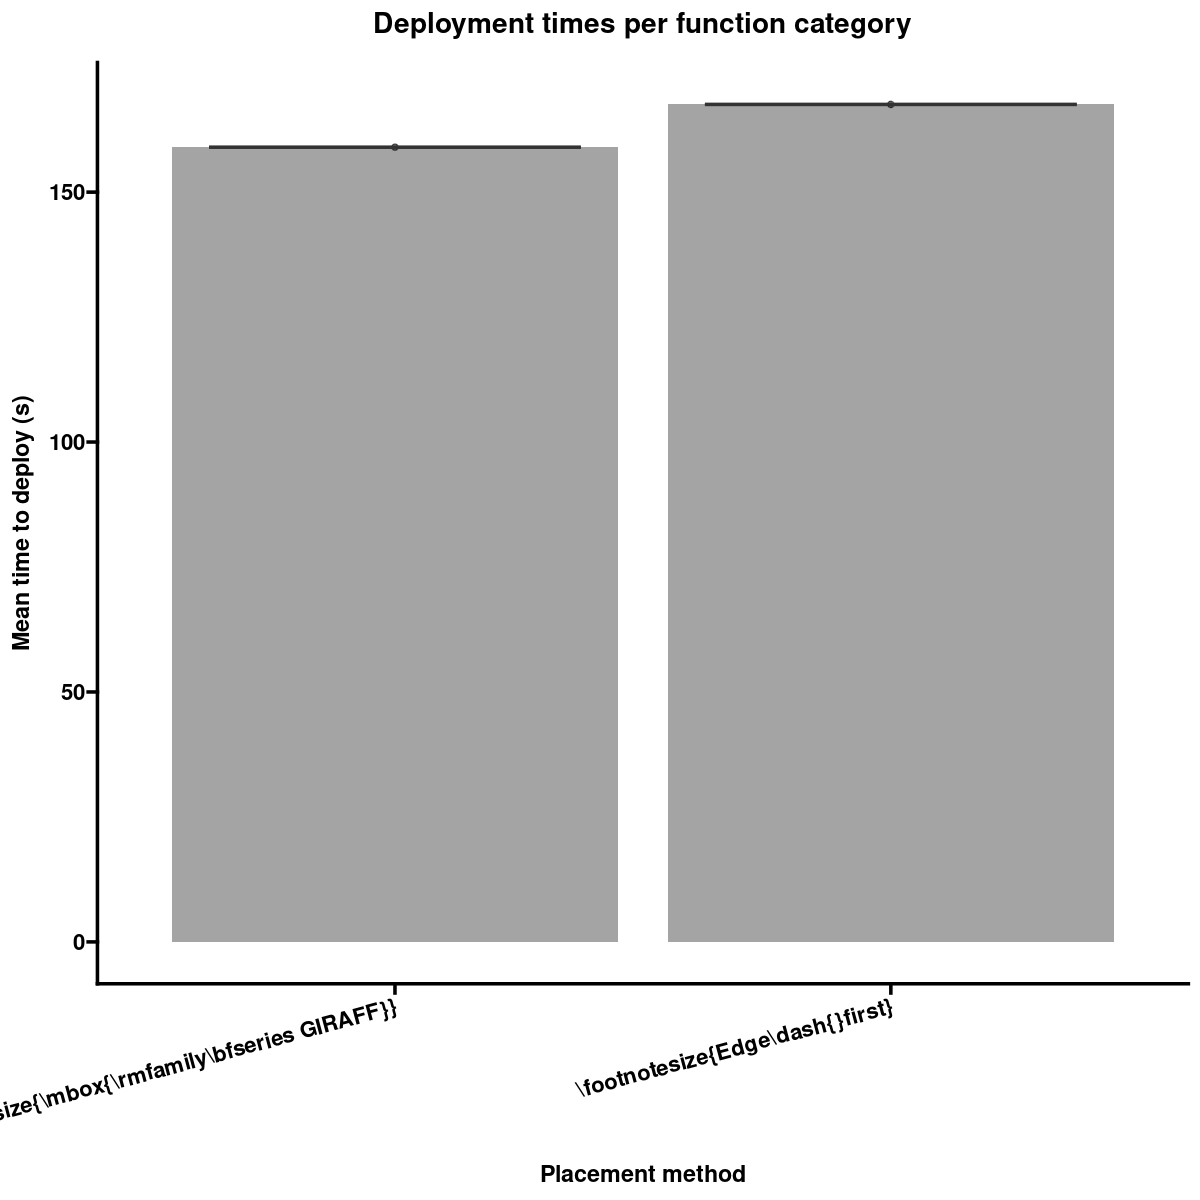

In [59]:
df <- raw.deployment_times %>% 
    group_by(folder, metric_group) %>%
    summarise(value = mean(value)) %>%
    correct_names() %>% 
    mutate(group = "sdlkfjh") %>%
    ungroup()

p <- ggplot(data= df, aes(alpha=1)) +  
    #  facet_grid(~var_facet) +
     theme(legend.position="none") +scale_alpha_continuous(guide = "none") +
    labs(
    y = "Mean time to deploy (s)",
    x = "Placement method",
    ) +
       theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7)),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)

                                  ) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    # theme(legend.position = c(.8, .5)) +
    guides(colour = guide_legend(ncol = 1)) +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)
fig(10, 10)
plots.deploymenttimes.w <- GRAPH_ONE_COLUMN_WIDTH
plots.deploymenttimes.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.deploymenttimes.caption = "Time to find a fog node for a function"
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1fs$}",Letters, mean))
}
plots.deploymenttimes <- anova_boxplot(p, df , "Placement method", "value", "group", mean_cb, c(4,6,19))
plots.deploymenttimes + labs(title = plots.deployment_times.caption)

In [60]:
# plots.skew.data <- bids_won_function %>% 
#     extract_function_name_info() %>%
#     left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
#     left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
#     mutate(ratio_func_ll = total_func_ll / total_func) %>%
#     mutate(ratio_func_ll = sprintf("%.1f%% ll ƒ", ratio_func_ll *100)) %>% 
#     group_by(folder, metric_group, load_type, latency_type) %>%
#     summarise(spending = (mean(cost) - median(cost)) / sd(cost)) %>%
#     mutate(fn_category = sprintf("%s\n%s", latency_type, load_type)) %>%
#     correct_names()

# my_comparisons = combn(unique(plots.skew.data$`Placement method`), 2)
# my_comparisons = apply(my_comparisons, 2, list)
# my_comparisons <- lapply(my_comparisons, unlist)

# plots.skew.caption <- "Nonparametric skew of a client's spending by function type"
# plots.skew.w <- GRAPH_TWO_COLUMN_WIDTH
# plots.skew.h <- GRAPH_ONE_COLUMN_HEIGHT

# fig(plots.skew.w, plots.skew.h)

# plots.skew <- plots.skew.data %>%
#     # summarySE("cost", c("metric_group", "requests", "fn_category", "level_value"), conf.interval = .95) %>%
#     # correct_names() %>%
#     ggplot(aes(alpha=0, x = `Placement method`, y = spending, shape = `Placement method`, color = `Placement method`, fill = `Placement method`)) +
#     # facet_grid(cols = vars(ratio_func_ll), rows= vars(fn_category), scales = "free")+
#     facet_grid(cols = vars(fn_category))+
#     geom_boxplot()+
#     geom_beeswarm()+
#     stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
#     # geom_hline(yintercept=1) +
#     scale_alpha_continuous(guide = "none") +
#     labs(
#         subtitle = "A positive skew indicates a tendency of\nthe spending distribution to be on the high side",
#         y = "Skew",
#         x = "Placement method",
#     ) +
#     theme( legend.background = element_rect(fill=alpha("white", .7),
#                                 size=0.2, color = alpha("white", .7))) +
#     theme(legend.spacing.y = unit(0, 'cm'),
#         legend.margin=margin(0,0,0,0), 
#         legend.box.margin=margin(-10,-10,-10,-10),
#         axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
#         )+
#     # scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
#     # theme(legend.position = c(.5, .93)) +
#     theme(legend.position = "top") +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)+
#     guides(colour = guide_legend(nrow = 1))
    

# plots.skew + labs(title = plots.skew.caption)

In [65]:
plots.spending.data <- bids_won_function %>% 
    extract_function_name_info() %>%
    # left_join(raw.nb_functions) %>%
    # mutate(ratio_func_ll = total_func_ll / total_func) %>%
    # mutate(ratio_func_ll = sprintf("%.1f%% ll ƒ", ratio_func_ll *100)) %>% 
    group_by(folder, metric_group) %>%
    summarise(spending = mean(cost)) %>%
    # mutate(fn_category = sprintf("%s\n%s", latency_type, load_type)) %>%
    correct_names()

# plots.spending.data %>% 
#     group_by(metric_group) %>% 
#     summarise(spending = mean(spending))

# my_comparisons = combn(unique(plots.spending.data$`Placement method`), 2)
# my_comparisons = apply(my_comparisons, 2, list)
# my_comparisons <- lapply(my_comparisons, unlist)

plots.spending.caption <- "Mean cost of a function by type"
plots.spending.w <- GRAPH_TWO_COLUMN_WIDTH
plots.spending.h <- GRAPH_ONE_COLUMN_HEIGHT

# fig(plots.spending.w, plots.spending.h)
# fig(15, 15)
# plots.spending.raw <- plots.spending.data %>%
#     # summarySE("cost", c("metric_group", "requests", "fn_category", "level_value"), conf.interval = .95) %>%
#     # correct_names() %>%
#     ggplot(aes(alpha=0, x = `Placement method`, y = spending, shape = `Placement method`, color = `Placement method`)) +
#     # facet_grid(cols = vars(ratio_func_ll), rows= vars(fn_category), scales = "free")+
#     facet_grid(cols=vars(fn_category))+
#     stat_summary(fun = mean, geom = "col", mapping = aes(fill =`Placement method`)) +
#     geom_boxplot()+
#     geom_beeswarm()+
#     stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
#     stat_summary(fun = mean, geom = "text", mapping = aes(label=sprintf("\\footnotesize{$\\mu=%.1f$}",..y..)), position = position_stack(vjust = .5, reverse = T), color = "black") +
#     # geom_hline(yintercept=1) +
#     scale_alpha_continuous(guide = "none") +
#     labs(
#         y = "Function cost (\\$/millicpu)",
#         x = "Placement method",
#     ) +
#     theme( legend.background = element_rect(fill=alpha("white", .7),
#                                 size=0.2, color = alpha("white", .7))) +
#     theme(legend.spacing.y = unit(0, 'cm'),
#         legend.margin=margin(0,0,0,0), 
#         legend.box.margin=margin(-10,-10,-10,-10),
#         axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
#         )+
#     # scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
#     # theme(legend.position = c(.5, .93)) +
#     theme(legend.position = "top") +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)+
#     guides(colour = guide_legend(nrow = 1))
    

# plots.spending.raw + labs(title = plots.spending.caption)

`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'var_facet'. You can override using the `.groups` argument.


class_x,value_y,var_facet
<chr>,<dbl>,<chr>


# A tibble: 0 × 3
# ℹ 3 variables: class_x <chr>, value_y <dbl>, var_facet <chr>


Warning message in qtukey(conf.level, length(means), x$df.residual):
“NaNs produced”


[1] "Shapiro (p should be ns)"


An error occured with the anova pre checks



NULL

<simpleError in shapiro.test(x = aov_residuals): sample size must be between 3 and 5000>
# A tibble: 2 × 3
  class_x                                               value_y var_facet
  <chr>                                                   <dbl> <chr>    
1 "\\footnotesize{\\mbox{\\rmfamily\\bfseries GIRAFF}}"  0.0117 toto     
2 "\\footnotesize{Edge\\dash{}first}"                    0.0185 toto     


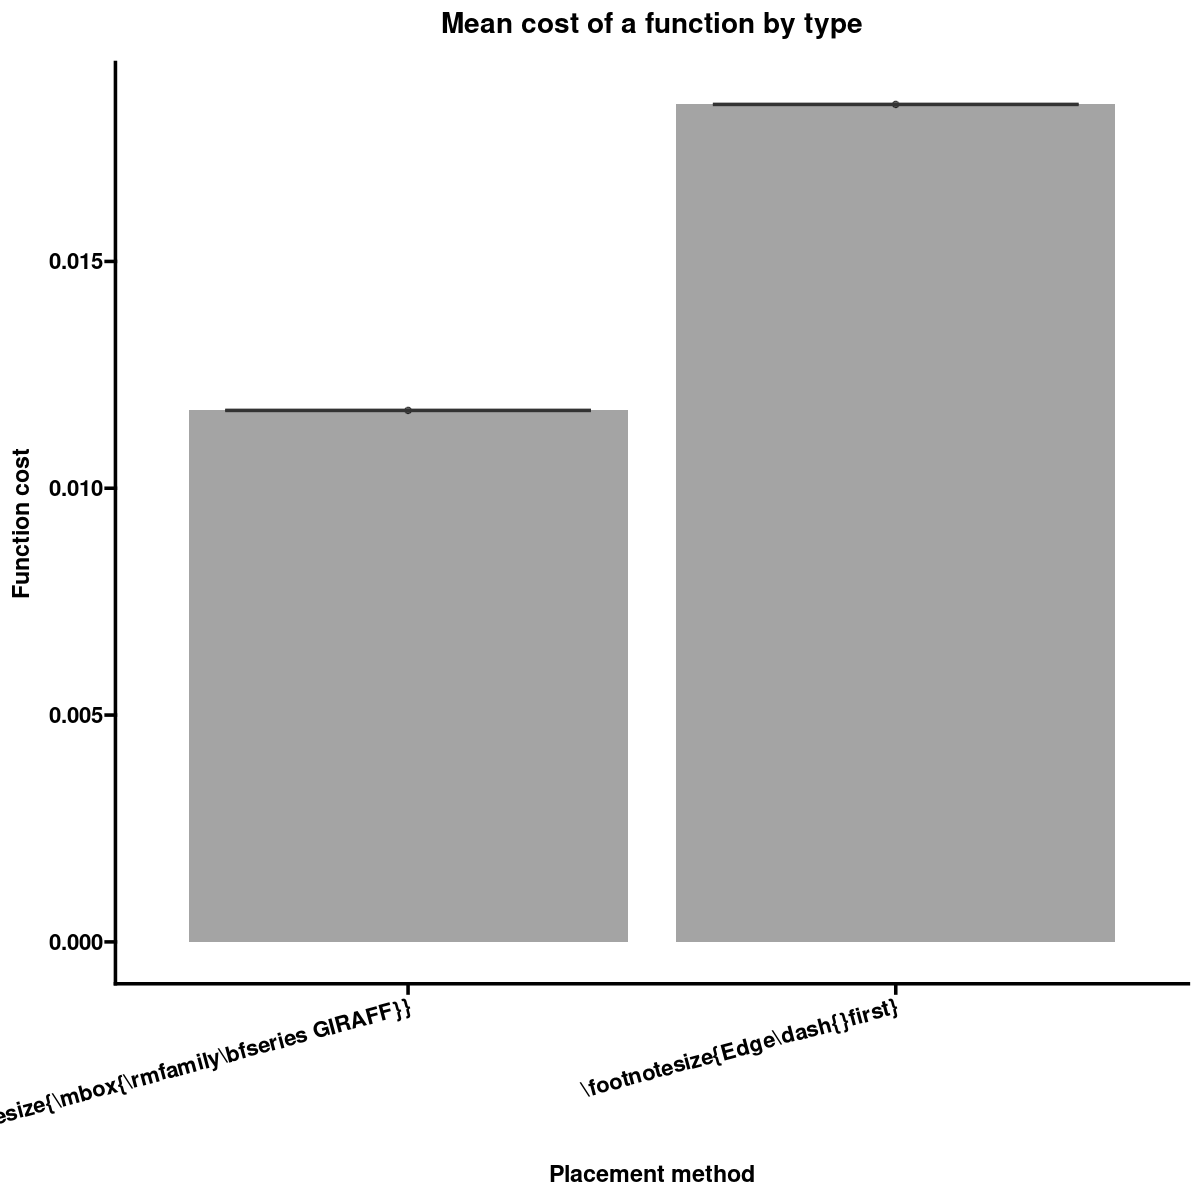

In [64]:
df <- plots.spending.data %>% 
    mutate(group = "toto") %>%
    ungroup()

p <- ggplot(data= df, aes(alpha=1)) +  
    #  facet_grid(~var_facet) +
     theme(legend.position="none") +
     scale_alpha_continuous(guide = "none") +
    labs(
        y = "Function cost",
        x = "Placement method",
    ) +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                size=0.2, color = alpha("white", .7))) +
    theme(legend.spacing.y = unit(0, 'cm'),
        legend.margin=margin(0,0,0,0), 
        legend.box.margin=margin(-10,-10,-10,-10),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
        )+
    # scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    # theme(legend.position = c(.5, .93)) +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    guides(colour = guide_legend(nrow = 1))

fig(10, 10)
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1f$}",Letters, mean))
}
plots.spending <- anova_boxplot(p, df , "Placement method", "spending", "group", mean_cb)
plots.spending + labs(title = plots.spending.caption)

In [66]:
# plots.nb_functions.data <- load_csv("provisioned_functions.csv") %>%
#     prepare() %>%
#     extract_function_name_info() %>%
#     group_by(folder, latency_type, load_type) %>%
#     summarise(provisioned = sum(value)) %>%
#     inner_join(raw.nb_functions.total %>% rename(target = total)) %>%
#     inner_join(raw.function_low_latency_load_category) %>%
#     mutate(ratio_deployed = provisioned / target) %>%
#     mutate(fn_category = sprintf("%s %s", latency_type, load_type)) 
plots.nb_functions.data <- raw.nb_functions %>%
    rowwise() %>%
    rename(ratio_deployed = nb_functions)

In [67]:
slice_sample(plots.nb_functions.data %>% ungroup(), n= 5)

folder,nb_functions_requested_total,nb_actual_functions,ratio_deployed
<chr>,<dbl>,<int>,<dbl>
metrics_valuation_rates.env_DEV-edge_first_valuation_rates_no-telemetry_2023-10-13-10-01,100,100,1.00
metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-10-23-12-45,100,97,0.97


In [68]:
# fig(7, 7)
# colnames(node_levels)
# plots.nb_functions.line.data <- load_csv("provisioned_functions.csv") %>%
#     prepare() %>%
#     extract_function_name_info() %>%
#     inner_join(bids_won_function) %>%
#     group_by(folder, latency_type, load_type, winner) %>%
#     summarise(provisioned = sum(value)) %>%
#     inner_join(raw.nb_functions.total %>% rename(target = total))  %>%
#     inner_join(raw.function_low_latency_load_category) %>%
#     left_join(node_levels %>% rename(winner = name)) %>%
#     mutate(ratio_deployed = provisioned / target) %>%
#     mutate(fn_category = sprintf("%s %s", latency_type, load_type)) %>%
#     summarySE("ratio_deployed", c("metric_group", "fn_category", "level_value"))

In [69]:
# plots.nb_functions.data = load_csv("provisioned_functions.csv") %>%
#     prepare() %>%
#     extract_function_name_info() %>%
#     inner_join(bids_won_function) %>%
#     group_by(folder, latency_type, load_type, winner) %>%
#     summarise(provisioned = sum(value)) %>%
#     inner_join(raw.nb_functions.total %>% rename(target = total))  %>%
#     inner_join(raw.function_low_latency_load_category) %>%
#     left_join(node_levels %>% rename(winner = name)) %>%
#     mutate(ratio_deployed = provisioned / target) %>%
#     mutate(fn_category = sprintf("%s\n%s", latency_type, load_type))

In [70]:
# colnames(plots.nb_functions.data)

# plots.nb_functions.data.processed = plots.nb_functions.data %>%
#     group_by(folder, metric_group, level_value, target) %>%
#     summarise(provisioned = sum(provisioned)) %>%
#     mutate(ratio_deployed = provisioned / target)

# slice_sample(plots.nb_functions.data.processed %>% ungroup(), n = 5)

In [71]:
escape_latex_special_chars <- function(text) {
  # Define special characters to escape
  special_chars <- c("%", "&", "#", "_", "\\$", "\\{", "\\}", "\\^", "\\~")

  # Escape each special character with a backslash
  for (char in special_chars) {
    text <- gsub(char, paste0("\\", substring(char, nchar(char), nchar(char))), text, fixed = TRUE)
  }

  return(text)
}


tibble_to_latex_tabular <- function(data, file) {
  cat("\\begin{tabular}{", paste0(rep("c", ncol(data)), collapse = " "), "}\n", file = file)
  cat("\\hline\n", file = file, append = TRUE)

  # Print column names with escaped special characters
  cat(paste0(escape_latex_special_chars(colnames(data)), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  cat("\\hline\n", file = file, append = TRUE)

  # Print rows with escaped special characters
  for (i in 1:nrow(data)) {
    cat(paste0(escape_latex_special_chars(as.character(data[i, ])), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  }

  cat("\\hline\n", file = file, append = TRUE)
  cat("\\end{tabular}", file = file, append = TRUE)
}


In [72]:
if (length(find.package("tikzDevice", quiet = TRUE))) {
    library(tikzDevice)
    options(tikzDefaultEngine = "xetex")
    options(
        tikzSanitizeCharacters = c("%", "&", "#", "\\$", "\\{", "\\}", "\\^", "\\~", "ƒ"),
        tikzReplacementCharacters = c("\\%", "\\&", "\\#", "\\\\$", "\\\\{", "\\\\}", "\\\\^", "\\\\~", "$f$")
    )
    options(tikzXelatexPackages = c(
        "\\usepackage{tikz}\n",
        "\\usepackage[active,tightpage,xetex]{preview}\n",
        "\\usepackage{fontspec,xunicode}\n",
        "\\PreviewEnvironment{pgfpicture}\n",
        "\\setlength\\PreviewBorder{0pt}\n",
        "\\newcommand{\\dash}{-}\n"
    ))
    options(
        tikzMetricPackages = c(
        "\\usepackage[T1]{fontenc}\n",
        "\\usetikzlibrary{calc}\n"
        ),
        tikzUnicodeMetricPackages = c(
        "\\usepackage[T1]{fontenc}\n",
        "\\usetikzlibrary{calc}\n",
        "\\usepackage{fontspec,xunicode}\n"
        )
        )
    # options(tikzMetricPackages = c("\\usepackage{preview}", "\\usepackage{pgf}", "\\usepackage{xcolor}"))

    tikzDevice::tikzTest()

    column_width = 7

    export_graph <- function(name, plot, width, height, caption) {
        tikzDevice::tikz(name, width = width, height = height, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
        print(plot)
        dev.off()

        # read the existing content of the file
        existing_content <- readLines(name)

        tex_width = 1
        if (width > GRAPH_ONE_COLUMN_WIDTH) {
           tex_width = 2
        }

        new_content <- c( 
            sprintf("\\newcommand{\\dash}{-}\n\\resizebox{%s\\columnwidth}{!}{", tex_width),
            existing_content,
            "}",
            sprintf("\\caption{%s}", caption)
            )

        # write the new content to the file
        writeLines(new_content, name)

        fig(width, height)
        print(plot + labs (title = caption))

    }


    # tikzDevice::tikz("./nodes.tex", width = 15, height = 5, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    # plot(net_connected, layout = coords, asp = 0.22, margin = -0, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
    # dev.off()

    export_graph("./jain.tex", plots.jains, plots.jains.w, plots.jains.h, plots.jains.caption)
    export_graph("./nb_deployed.tex", plots.nb_deployed, plots.nb_deployed.w, plots.nb_deployed.h, plots.nb_deployed.caption)
    export_graph("./respected_sla.tex", plots.respected_sla, plots.respected_sla.w, plots.respected_sla.h, plots.respected_sla.caption)
    # export_graph("./skew.tex", plots.skew, plots.skew.w, plots.skew.h, plots.skew.caption)
    export_graph("./spending.tex", plots.spending, plots.spending.w, plots.spending.h, plots.spending.caption)
    export_graph("./deploymenttimes.tex", plots.deploymenttimes, plots.deploymenttimes.w, plots.deploymenttimes.h, plots.deploymenttimes.caption)

    # output_file <- "nb_experiences_per_categories.tex"
    # tibble_to_latex_tabular(nb_experiences_per_categories, output_file)
}

